In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk
No vtk/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
win_id = 5

In [5]:
# stacks = ['MD661', 'MD662']
# stacks = ['MD661', 'ChatCryoJane201710']
stacks = ['MD589', 'MD594']
# stacks = ['MD589', 'MD594', 'MD661', 'ChatCryoJane201710']

In [6]:
windowing_properties = windowing_settings[win_id]
patch_size = windowing_properties['patch_size']
half_size = patch_size/2
spacing = windowing_properties['spacing']

sample_locations_allStacks = {}
for stack in stacks:
    w, h = metadata_cache['image_shape'][stack]
    sample_locations_allStacks[stack] = grid_parameters_to_sample_locations(grid_spec=(patch_size, spacing, w, h))

In [7]:
# addresses_df = DataFrame([(stack, sec, grid_idx) 
#            for stack in ['MD661', 'MD662'] 
#            for sec in np.arange(metadata_cache['section_limits'][stack][0], 
#                                 metadata_cache['section_limits'][stack][-1]+1)
#            for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#           columns=['stack', 'section', 'grid_idx'])

In [8]:
# location_column = [sample_locations_allStacks[addr['stack']][addr['grid_idx']]
# for i, addr in addresses_df.iterrows()]

# addresses_df = addresses_df.assign(location=location_column)

In [9]:
grid_indices_lookup_allStacks = {}
for stack in stacks:
    try:
        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=True, timestamp='latest')
    except:
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD594" "/home/yuncong/CSHL_labelings_v3/MD594" --exclude "*" --include "*contours*"
latest timestamp:  07302017183604


In [10]:
from itertools import chain
all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) for st in stacks))))

In [11]:
address_multidx = pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
           for stack in sorted(stacks)
           for sec in np.arange(metadata_cache['section_limits'][stack][0], 
                                metadata_cache['section_limits'][stack][-1]+1)
           for grid_idx in range(len(sample_locations_allStacks[stack]))], 
          names=['stack', 'section', 'grid_idx'])

In [12]:
address_label_df_allStacks = DataFrame(columns=all_labels,
    index=address_multidx, data=False)

In [13]:
# surround_margins = [200, 500]
surround_margins = [200]

In [14]:
# stack = 'MD661'
for stack in stacks:
# for stack in ['MD661']:
# for stack in ['ChatCryoJane201710']:

    prep_id = 2

    contours_df = DataManager.load_annotation_v4(stack=stack, by_human=True, suffix='contours', timestamp='latest')
    contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])

    contours_df = convert_annotation_v3_original_to_aligned_cropped(contours, stack=stack)
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=prep_id), is_dir=True)

    contours_grouped = contours_df.groupby('section')
    
    ##########################################
    
    for sec, cnt_group in contours_grouped:
        sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
        if is_invalid(sec=sec, stack=stack):
            continue
        polygons_this_sec = [(contour['name'], contour['vertices']) for contour_id, contour in cnt_group.iterrows()]
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, prep_id=prep_id)

        t = time.time()
        label_to_grid_indices_map = locate_patches_v2(grid_spec=win_id_to_gridspec(win_id=5, stack=stack), 
                                                      mask_tb=mask_tb, polygons=polygons_this_sec, \
                                                      surround_margins=surround_margins)
        sys.stderr.write("Identify in-polygon grid indices: %.2f s\n" % (time.time()-t))

        for label, grid_indices in label_to_grid_indices_map.iteritems():
            if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                continue
            sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
#             t = time.time()
            for grid_idx in grid_indices:
                address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
#             sys.stderr.write("%.2f s\n" % (time.time()-t))

    del contours_df, contours_grouped, contours

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


Computing class label to grid indices lookup-table for section 92...
Identify in-polygon grid indices: 0.40 s
MD589, sec 92: 7172 patches from label Cb.
MD589, sec 92: 1384 patches from label Cb_surround_200_noclass.
Computing class label to grid indices lookup-table for section 94...
Identify in-polygon grid indices: 0.12 s
MD589, sec 94: 23 patches from label VCA.
MD589, sec 94: 123 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 95...
Identify in-polygon grid indices: 0.12 s
MD589, sec 95: 43 patches from label VCA.
MD589, sec 95: 180 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 96...
Identify in-polygon grid indices: 0.14 s
MD589, sec 96: 69 patches from label VCA.
MD589, sec 96: 241 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 97...
Identify in-polygon grid indices: 0.16 s
MD589, sec 97: 114 patche

MD589, sec 110: 458 patches from label DC_surround_200_noclass.
MD589, sec 110: 135 patches from label DC_surround_200_Cb.
MD589, sec 110: 107 patches from label VCA_surround_200_Cb.
Computing class label to grid indices lookup-table for section 111...
Identify in-polygon grid indices: 0.69 s
MD589, sec 111: 408 patches from label VCA.
MD589, sec 111: 595 patches from label VCA_surround_200_noclass.
MD589, sec 111: 600 patches from label DC_surround_200_noclass.
MD589, sec 111: 31 patches from label VCA_surround_200_DC.
MD589, sec 111: 35 patches from label VCP_surround_200_VCA.
MD589, sec 111: 389 patches from label DC.
MD589, sec 111: 52 patches from label VCA_surround_200_VCP.
MD589, sec 111: 535 patches from label VCP_surround_200_noclass.
MD589, sec 111: 337 patches from label VCP.
MD589, sec 111: 58 patches from label VCP_surround_200_DC.
MD589, sec 111: 34 patches from label DC_surround_200_VCA.
MD589, sec 111: 42 patches from label DC_surround_200_VCP.
Computing class label to 

MD589, sec 121: 483 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 122...
Identify in-polygon grid indices: 0.70 s
MD589, sec 122: 142 patches from label DC.
MD589, sec 122: 13 patches from label VCA_surround_200_Pr5.
MD589, sec 122: 16 patches from label Pr5_surround_200_VCA.
MD589, sec 122: 252 patches from label VCP_surround_200_noclass.
MD589, sec 122: 29 patches from label Pr5.
MD589, sec 122: 28 patches from label DC_surround_200_VCP.
MD589, sec 122: 16 patches from label VCA.
MD589, sec 122: 239 patches from label VCA_surround_200_noclass.
MD589, sec 122: 197 patches from label Sp5I.
MD589, sec 122: 283 patches from label Pr5_surround_200_noclass.
MD589, sec 122: 40 patches from label VCP.
MD589, sec 122: 1 patches from label PBG.
MD589, sec 122: 49 patches from label VCP_surround_200_DC.
MD589, sec 122: 177 patches from label PBG_surround_200_noclass.
MD589, sec 122: 494 patches from label DC_surround_200_noclass.
MD

Identify in-polygon grid indices: 1.31 s
MD589, sec 132: 134 patches from label Sp5C_surround_200_Sp5I.
MD589, sec 132: 56 patches from label DC.
MD589, sec 132: 341 patches from label Sp5C_surround_200_noclass.
MD589, sec 132: 590 patches from label VLL_surround_200_noclass.
MD589, sec 132: 595 patches from label SNR_surround_200_noclass.
MD589, sec 132: 270 patches from label VLL.
MD589, sec 132: 458 patches from label Sp5O.
MD589, sec 132: 4 patches from label VLL_surround_200_PBG.
MD589, sec 132: 434 patches from label Sp5I.
MD589, sec 132: 570 patches from label Sp5O_surround_200_noclass.
MD589, sec 132: 160 patches from label Sp5C.
MD589, sec 132: 18 patches from label PBG.
MD589, sec 132: 247 patches from label PBG_surround_200_noclass.
MD589, sec 132: 144 patches from label Sp5O_surround_200_Sp5I.
MD589, sec 132: 114 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 132: 104 patches from label Sp5I_surround_200_Sp5C.
MD589, sec 132: 216 patches from label SNR.
MD589, sec 13

MD589, sec 138: 751 patches from label SNR_surround_200_noclass.
MD589, sec 138: 318 patches from label VLL.
MD589, sec 138: 947 patches from label Sp5O.
MD589, sec 138: 837 patches from label Sp5I.
MD589, sec 138: 775 patches from label Sp5O_surround_200_noclass.
MD589, sec 138: 430 patches from label Sp5C.
MD589, sec 138: 302 patches from label SC.
MD589, sec 138: 612 patches from label SC_surround_200_noclass.
MD589, sec 138: 645 patches from label Sp5O_surround_200_Sp5I.
MD589, sec 138: 583 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 138: 136 patches from label Sp5I_surround_200_Sp5C.
MD589, sec 138: 406 patches from label SNR.
MD589, sec 138: 307 patches from label DC_surround_200_noclass.
MD589, sec 138: 558 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 139...
Identify in-polygon grid indices: 1.63 s
MD589, sec 139: 142 patches from label Sp5C_surround_200_Sp5I.
MD589, sec 139: 26 patches from label DC.
MD58

MD589, sec 143: 123 patches from label Sp5I_surround_200_Sp5C.
MD589, sec 143: 490 patches from label SNR.
MD589, sec 143: 247 patches from label DC_surround_200_noclass.
MD589, sec 143: 835 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 144...
Identify in-polygon grid indices: 2.29 s
MD589, sec 144: 94 patches from label Sp5C_surround_200_Sp5I.
MD589, sec 144: 9 patches from label DC.
MD589, sec 144: 760 patches from label SC_surround_200_noclass.
MD589, sec 144: 497 patches from label VLL_surround_200_noclass.
MD589, sec 144: 149 patches from label SC_surround_200_IC.
MD589, sec 144: 1350 patches from label IC.
MD589, sec 144: 814 patches from label SNR_surround_200_noclass.
MD589, sec 144: 184 patches from label VLL.
MD589, sec 144: 330 patches from label X_surround_200_noclass.
MD589, sec 144: 913 patches from label IC_surround_200_noclass.
MD589, sec 144: 664 patches from label Sp5C_surround_200_noclass.
MD589, sec 144:

MD589, sec 148: 12 patches from label SNR_surround_200_SNC.
MD589, sec 148: 131 patches from label SNC_surround_200_SNR.
MD589, sec 148: 67 patches from label 8n.
MD589, sec 148: 787 patches from label Sp5C.
MD589, sec 148: 848 patches from label SC_surround_200_noclass.
MD589, sec 148: 245 patches from label SNC_surround_200_noclass.
MD589, sec 148: 31 patches from label X.
MD589, sec 148: 1249 patches from label IC.
MD589, sec 148: 11 patches from label SuVe_surround_200_8n.
MD589, sec 148: 12 patches from label SNC.
MD589, sec 148: 17 patches from label 8n_surround_200_SuVe.
MD589, sec 148: 484 patches from label SNR.
MD589, sec 148: 255 patches from label DC_surround_200_noclass.
MD589, sec 148: 194 patches from label SuVe.
MD589, sec 148: 1225 patches from label SC.
MD589, sec 148: 327 patches from label 8n_surround_200_noclass.
MD589, sec 148: 151 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 149...
Identify in-polygon grid 

MD589, sec 152: 314 patches from label 8n_surround_200_noclass.
MD589, sec 152: 163 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 153...
Identify in-polygon grid indices: 2.39 s
MD589, sec 153: 47 patches from label 7n.
MD589, sec 153: 529 patches from label SuVe_surround_200_noclass.
MD589, sec 153: 0 patches from label DC.
MD589, sec 153: 865 patches from label Sp5C_surround_200_noclass.
MD589, sec 153: 162 patches from label 5N.
MD589, sec 153: 400 patches from label VLL_surround_200_noclass.
MD589, sec 153: 457 patches from label 5N_surround_200_noclass.
MD589, sec 153: 172 patches from label SC_surround_200_IC.
MD589, sec 153: 860 patches from label SNR_surround_200_noclass.
MD589, sec 153: 106 patches from label VLL.
MD589, sec 153: 49 patches from label 7N.
MD589, sec 153: 319 patches from label 7n_surround_200_noclass.
MD589, sec 153: 772 patches from label IC_surround_200_noclass.
MD589, sec 153: 520 patches from label SN

MD589, sec 156: 323 patches from label 7n_surround_200_noclass.
MD589, sec 156: 959 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 157...
Identify in-polygon grid indices: 2.61 s
MD589, sec 157: 165 patches from label IC_surround_200_SC.
MD589, sec 157: 59 patches from label 7n.
MD589, sec 157: 446 patches from label 7N_surround_200_noclass.
MD589, sec 157: 560 patches from label SuVe_surround_200_noclass.
MD589, sec 157: 8 patches from label DC.
MD589, sec 157: 909 patches from label Sp5C_surround_200_noclass.
MD589, sec 157: 205 patches from label 5N.
MD589, sec 157: 395 patches from label VLL_surround_200_noclass.
MD589, sec 157: 524 patches from label 5N_surround_200_noclass.
MD589, sec 157: 166 patches from label SC_surround_200_IC.
MD589, sec 157: 852 patches from label SNR_surround_200_noclass.
MD589, sec 157: 96 patches from label VLL.
MD589, sec 157: 146 patches from label 7N.
MD589, sec 157: 332 patches from label 7n

Computing class label to grid indices lookup-table for section 161...
Identify in-polygon grid indices: 2.66 s
MD589, sec 161: 176 patches from label IC_surround_200_SC.
MD589, sec 161: 64 patches from label 7n.
MD589, sec 161: 519 patches from label SuVe_surround_200_noclass.
MD589, sec 161: 14 patches from label DC.
MD589, sec 161: 868 patches from label Sp5C_surround_200_noclass.
MD589, sec 161: 300 patches from label 5N.
MD589, sec 161: 577 patches from label VLL_surround_200_noclass.
MD589, sec 161: 597 patches from label 5N_surround_200_noclass.
MD589, sec 161: 185 patches from label SC_surround_200_IC.
MD589, sec 161: 787 patches from label SNR_surround_200_noclass.
MD589, sec 161: 175 patches from label VLL.
MD589, sec 161: 230 patches from label 7N.
MD589, sec 161: 756 patches from label IC_surround_200_noclass.
MD589, sec 161: 510 patches from label 7N_surround_200_noclass.
MD589, sec 161: 23 patches from label SNR_surround_200_SNC.
MD589, sec 161: 134 patches from label SNC_

MD589, sec 165: 652 patches from label APT_surround_200_noclass.
MD589, sec 165: 15 patches from label LVe_surround_200_DC.
MD589, sec 165: 29 patches from label SNR_surround_200_SNC.
MD589, sec 165: 125 patches from label SNC_surround_200_SNR.
MD589, sec 165: 376 patches from label DC_surround_200_noclass.
MD589, sec 165: 22 patches from label DC_surround_200_LVe.
MD589, sec 165: 597 patches from label Sp5C.
MD589, sec 165: 237 patches from label LVe_surround_200_noclass.
MD589, sec 165: 370 patches from label 7n_surround_200_noclass.
MD589, sec 165: 119 patches from label LRt.
MD589, sec 165: 290 patches from label SNC_surround_200_noclass.
MD589, sec 165: 1080 patches from label IC.
MD589, sec 165: 4 patches from label 5N_surround_200_SuVe.
MD589, sec 165: 5 patches from label SuVe_surround_200_5N.
MD589, sec 165: 29 patches from label SNC.
MD589, sec 165: 498 patches from label LRt_surround_200_noclass.
MD589, sec 165: 362 patches from label LSO_surround_200_noclass.
MD589, sec 165

MD589, sec 169: 115 patches from label LRt.
MD589, sec 169: 221 patches from label SNC_surround_200_noclass.
MD589, sec 169: 52 patches from label LSO.
MD589, sec 169: 1121 patches from label IC.
MD589, sec 169: 1046 patches from label SC_surround_200_noclass.
MD589, sec 169: 9 patches from label SNC.
MD589, sec 169: 488 patches from label LRt_surround_200_noclass.
MD589, sec 169: 324 patches from label LSO_surround_200_noclass.
MD589, sec 169: 418 patches from label APT.
MD589, sec 169: 441 patches from label SNR.
MD589, sec 169: 124 patches from label SuVe.
MD589, sec 169: 1875 patches from label SC.
MD589, sec 169: 185 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 170...
Identify in-polygon grid indices: 3.00 s
MD589, sec 170: 20 patches from label LPB_surround_200_Cb.
MD589, sec 170: 180 patches from label IC_surround_200_SC.
MD589, sec 170: 75 patches from label 7n.
MD589, sec 170: 551 patches from label 7N_surround_200_nocla

MD589, sec 175: 362 patches from label 7n_surround_200_noclass.
MD589, sec 175: 689 patches from label IC_surround_200_noclass.
MD589, sec 175: 30 patches from label SNR_surround_200_SNC.
MD589, sec 175: 344 patches from label Pn_surround_200_noclass.
MD589, sec 175: 133 patches from label SNC_surround_200_SNR.
MD589, sec 175: 84 patches from label IC_surround_200_SC.
MD589, sec 175: 247 patches from label SNC_surround_200_noclass.
MD589, sec 175: 851 patches from label IC.
MD589, sec 175: 30 patches from label SNC.
MD589, sec 175: 497 patches from label LRt_surround_200_noclass.
MD589, sec 175: 128 patches from label LRt.
MD589, sec 175: 357 patches from label SNR.
MD589, sec 175: 1939 patches from label SC.
MD589, sec 175: 361 patches from label LC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 176...
Identify in-polygon grid indices: 1.75 s
MD589, sec 176: 31 patches from label SNR_surround_200_SNC.
MD589, sec 176: 55 patches from label 7n.
MD58

MD589, sec 181: 51 patches from label SNR_surround_200_SNC.
MD589, sec 181: 416 patches from label Pn_surround_200_noclass.
MD589, sec 181: 130 patches from label SNC_surround_200_SNR.
MD589, sec 181: 1178 patches from label SC_surround_200_noclass.
MD589, sec 181: 273 patches from label SNC_surround_200_noclass.
MD589, sec 181: 695 patches from label IC.
MD589, sec 181: 51 patches from label SNC.
MD589, sec 181: 525 patches from label LRt_surround_200_noclass.
MD589, sec 181: 174 patches from label LRt.
MD589, sec 181: 265 patches from label SNR.
MD589, sec 181: 2001 patches from label SC.
MD589, sec 181: 560 patches from label LC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 182...
Identify in-polygon grid indices: 1.83 s
MD589, sec 182: 50 patches from label 7n.
MD589, sec 182: 520 patches from label 7N_surround_200_noclass.
MD589, sec 182: 1170 patches from label SC_surround_200_noclass.
MD589, sec 182: 144 patches from label SC_surround_200_I

MD589, sec 187: 28 patches from label SNC.
MD589, sec 187: 502 patches from label LRt_surround_200_noclass.
MD589, sec 187: 142 patches from label SNR.
MD589, sec 187: 2037 patches from label SC.
MD589, sec 187: 131 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 188...
Identify in-polygon grid indices: 1.63 s
MD589, sec 188: 122 patches from label IC_surround_200_SC.
MD589, sec 188: 44 patches from label 7n.
MD589, sec 188: 478 patches from label 7N_surround_200_noclass.
MD589, sec 188: 1205 patches from label SC_surround_200_noclass.
MD589, sec 188: 126 patches from label SC_surround_200_IC.
MD589, sec 188: 461 patches from label SNR_surround_200_noclass.
MD589, sec 188: 213 patches from label 7N.
MD589, sec 188: 304 patches from label 7n_surround_200_noclass.
MD589, sec 188: 211 patches from label Pn.
MD589, sec 188: 539 patches from label IC_surround_200_noclass.
MD589, sec 188: 30 patches from label SNR_surround_200_SNC.
MD589,

MD589, sec 195: 59 patches from label 7N.
MD589, sec 195: 304 patches from label 7n_surround_200_noclass.
MD589, sec 195: 78 patches from label RMC.
MD589, sec 195: 547 patches from label IC_surround_200_noclass.
MD589, sec 195: 530 patches from label Pn_surround_200_noclass.
MD589, sec 195: 58 patches from label IC_surround_200_SC.
MD589, sec 195: 104 patches from label IO.
MD589, sec 195: 426 patches from label IC.
MD589, sec 195: 554 patches from label IO_surround_200_noclass.
MD589, sec 195: 1910 patches from label SC.
MD589, sec 195: 1199 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 196...
Identify in-polygon grid indices: 1.41 s
MD589, sec 196: 48 patches from label 7n.
MD589, sec 196: 301 patches from label 7N_surround_200_noclass.
MD589, sec 196: 378 patches from label RMC_surround_200_noclass.
MD589, sec 196: 49 patches from label SC_surround_200_IC.
MD589, sec 196: 259 patches from label Pn.
MD589, sec 196: 30 patc

MD589, sec 202: 173 patches from label VTA.
MD589, sec 202: 524 patches from label Pn_surround_200_noclass.
MD589, sec 202: 1175 patches from label SC_surround_200_noclass.
MD589, sec 202: 186 patches from label IO.
MD589, sec 202: 328 patches from label IC.
MD589, sec 202: 579 patches from label IO_surround_200_noclass.
MD589, sec 202: 1794 patches from label SC.
MD589, sec 202: 472 patches from label VTA_surround_200_noclass.
MD589, sec 202: 35 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 203...
Identify in-polygon grid indices: 1.74 s
MD589, sec 203: 62 patches from label Tz.
MD589, sec 203: 16 patches from label 7n.
MD589, sec 203: 1 patches from label RMC_surround_200_VTA.
MD589, sec 203: 442 patches from label RMC_surround_200_noclass.
MD589, sec 203: 28 patches from label SC_surround_200_IC.
MD589, sec 203: 277 patches from label Pn.
MD589, sec 203: 10 patches from label 10N.
MD589, sec 203: 236 patches from label 7n_surro

MD589, sec 208: 529 patches from label Tz_surround_200_noclass.
MD589, sec 208: 226 patches from label VTA.
MD589, sec 208: 527 patches from label Pn_surround_200_noclass.
MD589, sec 208: 69 patches from label 10N_surround_200_12N.
MD589, sec 208: 3 patches from label 4N.
MD589, sec 208: 34 patches from label IC_surround_200_SC.
MD589, sec 208: 258 patches from label IO.
MD589, sec 208: 283 patches from label IC.
MD589, sec 208: 1146 patches from label SC_surround_200_noclass.
MD589, sec 208: 34 patches from label VTg.
MD589, sec 208: 517 patches from label VTA_surround_200_noclass.
MD589, sec 208: 340 patches from label 10N_surround_200_noclass.
MD589, sec 208: 390 patches from label 12N_surround_200_noclass.
MD589, sec 208: 14 patches from label VTA_surround_200_RMC.
MD589, sec 208: 710 patches from label IO_surround_200_noclass.
MD589, sec 208: 1693 patches from label SC.
MD589, sec 208: 174 patches from label 4N_surround_200_noclass.
Computing class label to grid indices lookup-tab

MD589, sec 213: 25 patches from label SC_surround_200_IC.
MD589, sec 213: 366 patches from label Pn.
MD589, sec 213: 24 patches from label 10N.
MD589, sec 213: 54 patches from label RMC.
MD589, sec 213: 167 patches from label 12N.
MD589, sec 213: 473 patches from label IC_surround_200_noclass.
MD589, sec 213: 505 patches from label Tz_surround_200_noclass.
MD589, sec 213: 517 patches from label Pn_surround_200_noclass.
MD589, sec 213: 126 patches from label 10N_surround_200_12N.
MD589, sec 213: 1100 patches from label SC_surround_200_noclass.
MD589, sec 213: 224 patches from label IO.
MD589, sec 213: 247 patches from label IC.
MD589, sec 213: 334 patches from label 10N_surround_200_noclass.
MD589, sec 213: 533 patches from label 12N_surround_200_noclass.
MD589, sec 213: 787 patches from label IO_surround_200_noclass.
MD589, sec 213: 1608 patches from label SC.
MD589, sec 213: 29 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 214...

MD589, sec 217: 742 patches from label IO_surround_200_noclass.
MD589, sec 217: 1535 patches from label SC.
MD589, sec 217: 7 patches from label 10N_surround_200_AP.
MD589, sec 217: 26 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 218...
Identify in-polygon grid indices: 1.83 s
MD589, sec 218: 19 patches from label 12N_surround_200_10N.
MD589, sec 218: 58 patches from label Tz.
MD589, sec 218: 384 patches from label 3N_surround_200_noclass.
MD589, sec 218: 1 patches from label 12N_surround_200_AP.
MD589, sec 218: 77 patches from label 3N.
MD589, sec 218: 22 patches from label SC_surround_200_IC.
MD589, sec 218: 402 patches from label Pn.
MD589, sec 218: 189 patches from label AP_surround_200_noclass.
MD589, sec 218: 19 patches from label 10N.
MD589, sec 218: 205 patches from label 12N.
MD589, sec 218: 466 patches from label IC_surround_200_noclass.
MD589, sec 218: 426 patches from label Tz_surround_200_noclass.
MD589, sec 218: 522

MD589, sec 224: 470 patches from label IC_surround_200_noclass.
MD589, sec 224: 282 patches from label Tz_surround_200_noclass.
MD589, sec 224: 532 patches from label Pn_surround_200_noclass.
MD589, sec 224: 1294 patches from label SC_surround_200_noclass.
MD589, sec 224: 154 patches from label IO.
MD589, sec 224: 241 patches from label IC.
MD589, sec 224: 85 patches from label AP.
MD589, sec 224: 574 patches from label 12N_surround_200_noclass.
MD589, sec 224: 696 patches from label IO_surround_200_noclass.
MD589, sec 224: 1623 patches from label SC.
MD589, sec 224: 46 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 225...
Identify in-polygon grid indices: 1.87 s
MD589, sec 225: 51 patches from label IC_surround_200_SC.
MD589, sec 225: 339 patches from label IPR_surround_200_noclass.
MD589, sec 225: 126 patches from label RtTg_surround_200_Pn.
MD589, sec 225: 297 patches from label RtTg.
MD589, sec 225: 467 patches from label RtTg_

MD589, sec 230: 13 patches from label IPR_surround_200_IPA.
MD589, sec 230: 12 patches from label IF_surround_200_IPA.
MD589, sec 230: 78 patches from label IPC_surround_200_IPR.
MD589, sec 230: 39 patches from label IPA_surround_200_IPR.
MD589, sec 230: 212 patches from label MnR.
MD589, sec 230: 25 patches from label 10N_surround_200_12N.
MD589, sec 230: 287 patches from label IF_surround_200_noclass.
MD589, sec 230: 262 patches from label AP_surround_200_noclass.
MD589, sec 230: 43 patches from label IPC_surround_200_MnR.
MD589, sec 230: 46 patches from label AP.
MD589, sec 230: 53 patches from label MnR_surround_200_IPC.
MD589, sec 230: 59 patches from label IO.
MD589, sec 230: 156 patches from label IPA_surround_200_noclass.
MD589, sec 230: 306 patches from label IC.
MD589, sec 230: 13 patches from label IPA_surround_200_IF.
MD589, sec 230: 125 patches from label IPC.
MD589, sec 230: 14 patches from label IPA.
MD589, sec 230: 14 patches from label MnR_surround_200_IPA.
MD589, sec 

Identify in-polygon grid indices: 1.24 s
MD589, sec 237: 16 patches from label 12N_surround_200_10N.
MD589, sec 237: 346 patches from label 3N_surround_200_noclass.
MD589, sec 237: 20 patches from label 4N_surround_200_3N.
MD589, sec 237: 67 patches from label 3N.
MD589, sec 237: 100 patches from label SC_surround_200_IC.
MD589, sec 237: 16 patches from label 10N.
MD589, sec 237: 206 patches from label 12N.
MD589, sec 237: 542 patches from label IC_surround_200_noclass.
MD589, sec 237: 123 patches from label 10N_surround_200_12N.
MD589, sec 237: 4 patches from label 4N.
MD589, sec 237: 1363 patches from label SC_surround_200_noclass.
MD589, sec 237: 436 patches from label IC.
MD589, sec 237: 288 patches from label 10N_surround_200_noclass.
MD589, sec 237: 614 patches from label 12N_surround_200_noclass.
MD589, sec 237: 1984 patches from label SC.
MD589, sec 237: 168 patches from label 4N_surround_200_noclass.
MD589, sec 237: 4 patches from label 3N_surround_200_4N.
MD589, sec 237: 97 p

MD589, sec 244: 145 patches from label IO.
MD589, sec 244: 591 patches from label IC.
MD589, sec 244: 318 patches from label 10N_surround_200_noclass.
MD589, sec 244: 499 patches from label 12N_surround_200_noclass.
MD589, sec 244: 704 patches from label IO_surround_200_noclass.
MD589, sec 244: 2110 patches from label SC.
MD589, sec 244: 117 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 245...
Identify in-polygon grid indices: 1.94 s
MD589, sec 245: 20 patches from label RPF_surround_200_SC.
MD589, sec 245: 26 patches from label 12N_surround_200_10N.
MD589, sec 245: 7 patches from label Gr_surround_200_10N.
MD589, sec 245: 154 patches from label RtTg_surround_200_Pn.
MD589, sec 245: 24 patches from label 10N_surround_200_MVe.
MD589, sec 245: 530 patches from label RMC_surround_200_noclass.
MD589, sec 245: 10 patches from label MVe_surround_200_12N.
MD589, sec 245: 295 patches from label RtTg.
MD589, sec 245: 450 patches from label

MD589, sec 250: 5 patches from label 10N_surround_200_Gr.
MD589, sec 250: 57 patches from label Gr.
MD589, sec 250: 15 patches from label Tz_surround_200_RtTg.
MD589, sec 250: 84 patches from label Pn_surround_200_RtTg.
MD589, sec 250: 247 patches from label 10N_surround_200_noclass.
MD589, sec 250: 2 patches from label Pn_surround_200_Tz.
MD589, sec 250: 499 patches from label MVe.
MD589, sec 250: 741 patches from label IO_surround_200_noclass.
MD589, sec 250: 2088 patches from label SC.
MD589, sec 250: 121 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 251...
Identify in-polygon grid indices: 1.73 s
MD589, sec 251: 46 patches from label Tz.
MD589, sec 251: 22 patches from label 7n.
MD589, sec 251: 463 patches from label RMC_surround_200_noclass.
MD589, sec 251: 130 patches from label SC_surround_200_IC.
MD589, sec 251: 368 patches from label Pn.
MD589, sec 251: 3 patches from label 10N.
MD589, sec 251: 148 patches from label RMC.

MD589, sec 258: 103 patches from label RMC.
MD589, sec 258: 279 patches from label 7n_surround_200_noclass.
MD589, sec 258: 602 patches from label IC_surround_200_noclass.
MD589, sec 258: 467 patches from label Tz_surround_200_noclass.
MD589, sec 258: 543 patches from label Pn_surround_200_noclass.
MD589, sec 258: 127 patches from label IC_surround_200_SC.
MD589, sec 258: 156 patches from label IO.
MD589, sec 258: 775 patches from label IC.
MD589, sec 258: 797 patches from label IO_surround_200_noclass.
MD589, sec 258: 1992 patches from label SC.
MD589, sec 258: 1201 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 259...
Identify in-polygon grid indices: 1.63 s
MD589, sec 259: 73 patches from label Tz.
MD589, sec 259: 34 patches from label 7n.
MD589, sec 259: 411 patches from label RMC_surround_200_noclass.
MD589, sec 259: 132 patches from label SC_surround_200_IC.
MD589, sec 259: 325 patches from label Pn.
MD589, sec 259: 93 p

MD589, sec 265: 136 patches from label LC.
MD589, sec 265: 121 patches from label RMC.
MD589, sec 265: 287 patches from label 7n_surround_200_noclass.
MD589, sec 265: 653 patches from label IC_surround_200_noclass.
MD589, sec 265: 520 patches from label Tz_surround_200_noclass.
MD589, sec 265: 515 patches from label Pn_surround_200_noclass.
MD589, sec 265: 121 patches from label IO.
MD589, sec 265: 914 patches from label IC.
MD589, sec 265: 567 patches from label IO_surround_200_noclass.
MD589, sec 265: 1695 patches from label SC.
MD589, sec 265: 485 patches from label LC_surround_200_noclass.
MD589, sec 265: 115 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 266...
Identify in-polygon grid indices: 1.71 s
MD589, sec 266: 96 patches from label Tz.
MD589, sec 266: 39 patches from label 7n.
MD589, sec 266: 432 patches from label RMC_surround_200_noclass.
MD589, sec 266: 122 patches from label SC_surround_200_IC.
MD589, sec 266: 302 p

MD589, sec 271: 463 patches from label LC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 272...
Identify in-polygon grid indices: 1.41 s
MD589, sec 272: 41 patches from label Tz.
MD589, sec 272: 105 patches from label IC_surround_200_SC.
MD589, sec 272: 39 patches from label 7n.
MD589, sec 272: 118 patches from label SC_surround_200_IC.
MD589, sec 272: 73 patches from label LC.
MD589, sec 272: 259 patches from label Pn.
MD589, sec 272: 297 patches from label 7n_surround_200_noclass.
MD589, sec 272: 716 patches from label IC_surround_200_noclass.
MD589, sec 272: 342 patches from label Tz_surround_200_noclass.
MD589, sec 272: 488 patches from label Pn_surround_200_noclass.
MD589, sec 272: 1080 patches from label SC_surround_200_noclass.
MD589, sec 272: 1039 patches from label IC.
MD589, sec 272: 440 patches from label LRt_surround_200_noclass.
MD589, sec 272: 84 patches from label LRt.
MD589, sec 272: 1446 patches from label SC.
MD589, sec 272: 448 p

MD589, sec 278: 23 patches from label SNR_surround_200_SNC.
MD589, sec 278: 465 patches from label Pn_surround_200_noclass.
MD589, sec 278: 97 patches from label SNC_surround_200_SNR.
MD589, sec 278: 624 patches from label Sp5C.
MD589, sec 278: 137 patches from label LRt.
MD589, sec 278: 255 patches from label SNC_surround_200_noclass.
MD589, sec 278: 1137 patches from label IC.
MD589, sec 278: 23 patches from label SNC.
MD589, sec 278: 525 patches from label LRt_surround_200_noclass.
MD589, sec 278: 206 patches from label SNR.
MD589, sec 278: 1278 patches from label SC.
MD589, sec 278: 996 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 279...
Identify in-polygon grid indices: 2.02 s
MD589, sec 279: 40 patches from label 7n.
MD589, sec 279: 406 patches from label 7N_surround_200_noclass.
MD589, sec 279: 825 patches from label Sp5C_surround_200_noclass.
MD589, sec 279: 120 patches from label SC_surround_200_IC.
MD589, sec 279: 

MD589, sec 284: 918 patches from label SC_surround_200_noclass.
MD589, sec 284: 241 patches from label SNC_surround_200_noclass.
MD589, sec 284: 1233 patches from label IC.
MD589, sec 284: 24 patches from label SNC.
MD589, sec 284: 550 patches from label LRt_surround_200_noclass.
MD589, sec 284: 159 patches from label LRt.
MD589, sec 284: 296 patches from label SNR.
MD589, sec 284: 1099 patches from label SC.
MD589, sec 284: 101 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 285...
Identify in-polygon grid indices: 2.10 s
MD589, sec 285: 99 patches from label IC_surround_200_SC.
MD589, sec 285: 43 patches from label 7n.
MD589, sec 285: 534 patches from label 7N_surround_200_noclass.
MD589, sec 285: 909 patches from label SC_surround_200_noclass.
MD589, sec 285: 117 patches from label SC_surround_200_IC.
MD589, sec 285: 681 patches from label SNR_surround_200_noclass.
MD589, sec 285: 231 patches from label 7N.
MD589, sec 285: 304 pa

MD589, sec 290: 224 patches from label 7N.
MD589, sec 290: 23 patches from label LVe_surround_200_SuVe.
MD589, sec 290: 835 patches from label IC_surround_200_noclass.
MD589, sec 290: 599 patches from label APT_surround_200_noclass.
MD589, sec 290: 6 patches from label APT_surround_200_SC.
MD589, sec 290: 541 patches from label Sol_surround_200_noclass.
MD589, sec 290: 15 patches from label SNR_surround_200_SNC.
MD589, sec 290: 474 patches from label Pn_surround_200_noclass.
MD589, sec 290: 107 patches from label SNC_surround_200_SNR.
MD589, sec 290: 598 patches from label LPB_surround_200_noclass.
MD589, sec 290: 1014 patches from label Sp5C.
MD589, sec 290: 264 patches from label LRt.
MD589, sec 290: 243 patches from label SNC_surround_200_noclass.
MD589, sec 290: 1092 patches from label IC.
MD589, sec 290: 268 patches from label LPB.
MD589, sec 290: 15 patches from label SNC.
MD589, sec 290: 571 patches from label LRt_surround_200_noclass.
MD589, sec 290: 7 patches from label SC_sur

MD589, sec 295: 232 patches from label 5N.
MD589, sec 295: 518 patches from label VLL_surround_200_noclass.
MD589, sec 295: 548 patches from label 5N_surround_200_noclass.
MD589, sec 295: 48 patches from label SC_surround_200_IC.
MD589, sec 295: 0 patches from label Pn.
MD589, sec 295: 944 patches from label SNR_surround_200_noclass.
MD589, sec 295: 139 patches from label VLL.
MD589, sec 295: 282 patches from label 7N.
MD589, sec 295: 305 patches from label 7n_surround_200_noclass.
MD589, sec 295: 35 patches from label Amb.
MD589, sec 295: 305 patches from label Amb_surround_200_noclass.
MD589, sec 295: 934 patches from label IC_surround_200_noclass.
MD589, sec 295: 863 patches from label Sp5C_surround_200_noclass.
MD589, sec 295: 5 patches from label SNR_surround_200_SNC.
MD589, sec 295: 319 patches from label Pn_surround_200_noclass.
MD589, sec 295: 140 patches from label SNC_surround_200_SNR.
MD589, sec 295: 483 patches from label LPB_surround_200_noclass.
MD589, sec 295: 958 patche

MD589, sec 301: 277 patches from label 5N.
MD589, sec 301: 637 patches from label VLL_surround_200_noclass.
MD589, sec 301: 568 patches from label 5N_surround_200_noclass.
MD589, sec 301: 918 patches from label SNR_surround_200_noclass.
MD589, sec 301: 246 patches from label VLL.
MD589, sec 301: 65 patches from label LSO.
MD589, sec 301: 6 patches from label LPB_surround_200_Cb.
MD589, sec 301: 350 patches from label X_surround_200_noclass.
MD589, sec 301: 785 patches from label IC_surround_200_noclass.
MD589, sec 301: 830 patches from label Sp5C_surround_200_noclass.
MD589, sec 301: 146 patches from label Cb_surround_200_IC.
MD589, sec 301: 23 patches from label SNR_surround_200_SNC.
MD589, sec 301: 129 patches from label SNC_surround_200_SNR.
MD589, sec 301: 185 patches from label IC_surround_200_Cb.
MD589, sec 301: 1065 patches from label Cb_surround_200_noclass.
MD589, sec 301: 889 patches from label Sp5C.
MD589, sec 301: 144 patches from label LRt.
MD589, sec 301: 263 patches from

MD589, sec 305: 23 patches from label SNR_surround_200_RR.
MD589, sec 305: 334 patches from label 7n_surround_200_noclass.
MD589, sec 305: 287 patches from label SNC_surround_200_noclass.
MD589, sec 305: 34 patches from label MiTg.
MD589, sec 305: 762 patches from label IC.
MD589, sec 305: 43 patches from label LPB.
MD589, sec 305: 35 patches from label SNC.
MD589, sec 305: 523 patches from label LRt_surround_200_noclass.
MD589, sec 305: 2 patches from label X_surround_200_8n.
MD589, sec 305: 617 patches from label SNR.
MD589, sec 305: 314 patches from label DC_surround_200_noclass.
MD589, sec 305: 258 patches from label 7N.
MD589, sec 305: 166 patches from label SC.
MD589, sec 305: 348 patches from label 8n_surround_200_noclass.
MD589, sec 305: 294 patches from label LSO_surround_200_noclass.
MD589, sec 305: 110 patches from label LRt.
Computing class label to grid indices lookup-table for section 306...
Identify in-polygon grid indices: 2.35 s
MD589, sec 306: 51 patches from label 7n

MD589, sec 309: 337 patches from label X_surround_200_noclass.
MD589, sec 309: 567 patches from label SNR.
MD589, sec 309: 12 patches from label SNR_surround_200_SNC.
MD589, sec 309: 126 patches from label SNC_surround_200_SNR.
MD589, sec 309: 50 patches from label 8n.
MD589, sec 309: 239 patches from label LPB_surround_200_noclass.
MD589, sec 309: 1 patches from label 8n_surround_200_X.
MD589, sec 309: 707 patches from label Sp5C.
MD589, sec 309: 315 patches from label 8n_surround_200_noclass.
MD589, sec 309: 14 patches from label LRt.
MD589, sec 309: 220 patches from label SNC_surround_200_noclass.
MD589, sec 309: 40 patches from label X.
MD589, sec 309: 17 patches from label LPB.
MD589, sec 309: 12 patches from label SNC.
MD589, sec 309: 301 patches from label LRt_surround_200_noclass.
MD589, sec 309: 1 patches from label X_surround_200_8n.
MD589, sec 309: 2 patches from label DC_surround_200_X.
MD589, sec 309: 311 patches from label DC_surround_200_noclass.
MD589, sec 309: 16 patch

MD589, sec 314: 119 patches from label VLL.
MD589, sec 314: 58 patches from label 7N.
MD589, sec 314: 292 patches from label 7n_surround_200_noclass.
MD589, sec 314: 340 patches from label X_surround_200_noclass.
MD589, sec 314: 43 patches from label 8n.
MD589, sec 314: 1 patches from label 8n_surround_200_X.
MD589, sec 314: 456 patches from label Sp5C.
MD589, sec 314: 13 patches from label PBG.
MD589, sec 314: 302 patches from label 8n_surround_200_noclass.
MD589, sec 314: 44 patches from label X.
MD589, sec 314: 2 patches from label X_surround_200_8n.
MD589, sec 314: 470 patches from label SNR.
MD589, sec 314: 345 patches from label DC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 315...
Identify in-polygon grid indices: 1.08 s
MD589, sec 315: 25 patches from label 7n.
MD589, sec 315: 277 patches from label 7N_surround_200_noclass.
MD589, sec 315: 320 patches from label PBG_surround_200_noclass.
MD589, sec 315: 46 patches from label DC.
MD589, s

MD589, sec 320: 160 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 320: 47 patches from label Sp5O_surround_200_Pr5DM.
MD589, sec 320: 893 patches from label Sp5O_surround_200_noclass.
MD589, sec 320: 6279 patches from label Cb.
MD589, sec 320: 9 patches from label X_surround_200_8n.
MD589, sec 320: 120 patches from label Sp5I_surround_200_Sp5C.
MD589, sec 320: 325 patches from label SNR.
MD589, sec 320: 334 patches from label DC_surround_200_noclass.
MD589, sec 320: 447 patches from label Pr5DM_surround_200_noclass.
MD589, sec 320: 305 patches from label 8n_surround_200_noclass.
MD589, sec 320: 16 patches from label DC_surround_200_Cb.
MD589, sec 320: 553 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 321...
Identify in-polygon grid indices: 1.86 s
MD589, sec 321: 114 patches from label Sp5C_surround_200_Sp5I.
MD589, sec 321: 36 patches from label DC.
MD589, sec 321: 377 patches from label Sp5C_surround_200_noclass.


MD589, sec 326: 618 patches from label Sp5I.
MD589, sec 326: 843 patches from label Sp5O_surround_200_noclass.
MD589, sec 326: 109 patches from label DC.
MD589, sec 326: 92 patches from label Sp5O_surround_200_Pr5VL.
MD589, sec 326: 445 patches from label DC_surround_200_noclass.
MD589, sec 326: 329 patches from label 8n_surround_200_noclass.
MD589, sec 326: 54 patches from label 8n.
MD589, sec 326: 650 patches from label Sp5I_surround_200_noclass.
MD589, sec 326: 154 patches from label Sp5O_surround_200_Sp5I.
MD589, sec 326: 85 patches from label Pr5VL_surround_200_Sp5O.
Computing class label to grid indices lookup-table for section 327...
Identify in-polygon grid indices: 1.10 s
MD589, sec 327: 901 patches from label Sp5O.
MD589, sec 327: 126 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 327: 54 patches from label 8n.
MD589, sec 327: 718 patches from label Pr5VL_surround_200_noclass.
MD589, sec 327: 547 patches from label Sp5I.
MD589, sec 327: 854 patches from label Sp5O_surr

MD589, sec 334: 353 patches from label Sp5I.
MD589, sec 334: 390 patches from label Sp5O_surround_200_noclass.
MD589, sec 334: 19 patches from label VCP.
MD589, sec 334: 62 patches from label VCP_surround_200_DC.
MD589, sec 334: 102 patches from label Sp5O_surround_200_Sp5I.
MD589, sec 334: 8 patches from label VCA_surround_200_8n.
MD589, sec 334: 78 patches from label Sp5I_surround_200_Sp5O.
MD589, sec 334: 539 patches from label DC_surround_200_noclass.
MD589, sec 334: 397 patches from label 8n_surround_200_noclass.
MD589, sec 334: 519 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 335...
Identify in-polygon grid indices: 0.82 s
MD589, sec 335: 9 patches from label 8n_surround_200_Pr5.
MD589, sec 335: 15 patches from label VCA.
MD589, sec 335: 251 patches from label DC.
MD589, sec 335: 7 patches from label Pr5_surround_200_8n.
MD589, sec 335: 11 patches from label Pr5_surround_200_VCA.
MD589, sec 335: 203 patches from labe

Identify in-polygon grid indices: 0.77 s
MD589, sec 341: 47 patches from label VCA_surround_200_DC.
MD589, sec 341: 297 patches from label DC.
MD589, sec 341: 13 patches from label VCA_surround_200_VCP.
MD589, sec 341: 363 patches from label VCP_surround_200_noclass.
MD589, sec 341: 43 patches from label DC_surround_200_VCA.
MD589, sec 341: 43 patches from label VCP_surround_200_8n.
MD589, sec 341: 36 patches from label 8n_surround_200_VCP.
MD589, sec 341: 53 patches from label DC_surround_200_VCP.
MD589, sec 341: 53 patches from label 8n_surround_200_VCA.
MD589, sec 341: 127 patches from label VCA.
MD589, sec 341: 387 patches from label VCA_surround_200_noclass.
MD589, sec 341: 152 patches from label 8n.
MD589, sec 341: 10 patches from label Sp5I.
MD589, sec 341: 6 patches from label VCP_surround_200_VCA.
MD589, sec 341: 156 patches from label VCP.
MD589, sec 341: 63 patches from label VCP_surround_200_DC.
MD589, sec 341: 46 patches from label VCA_surround_200_8n.
MD589, sec 341: 513 

MD589, sec 349: 67 patches from label DC_surround_200_VCA.
MD589, sec 349: 64 patches from label VCP_surround_200_VCA.
MD589, sec 349: 175 patches from label DC.
MD589, sec 349: 82 patches from label VCA_surround_200_VCP.
MD589, sec 349: 405 patches from label VCP_surround_200_noclass.
MD589, sec 349: 288 patches from label VCP.
MD589, sec 349: 461 patches from label DC_surround_200_noclass.
MD589, sec 349: 28 patches from label VCP_surround_200_DC.
Computing class label to grid indices lookup-table for section 350...
Identify in-polygon grid indices: 0.55 s
MD589, sec 350: 329 patches from label VCA.
MD589, sec 350: 483 patches from label VCA_surround_200_noclass.
MD589, sec 350: 491 patches from label DC_surround_200_noclass.
MD589, sec 350: 51 patches from label VCA_surround_200_DC.
MD589, sec 350: 77 patches from label VCP_surround_200_VCA.
MD589, sec 350: 150 patches from label DC.
MD589, sec 350: 96 patches from label VCA_surround_200_VCP.
MD589, sec 350: 420 patches from label V

Identify in-polygon grid indices: 0.19 s
MD589, sec 366: 178 patches from label VCA.
MD589, sec 366: 314 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 367...
Identify in-polygon grid indices: 0.16 s
MD589, sec 367: 128 patches from label VCA.
MD589, sec 367: 278 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 368...
Identify in-polygon grid indices: 0.14 s
MD589, sec 368: 77 patches from label VCA.
MD589, sec 368: 235 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 369...
Identify in-polygon grid indices: 0.11 s
MD589, sec 369: 43 patches from label VCA.
MD589, sec 369: 195 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 370...
Identify in-polygon grid indices: 0.44 s
MD589, sec 370: 25 patches from label VCA.
MD589, sec 370: 118 patches from label

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD594" "/home/yuncong/CSHL_labelings_v3/MD594" --exclude "*" --include "*contours*"
latest timestamp:  07302017183604


Computing class label to grid indices lookup-table for section 94...
Identify in-polygon grid indices: 0.12 s
MD594, sec 94: 18 patches from label VCA.
MD594, sec 94: 183 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 95...
Identify in-polygon grid indices: 0.15 s
MD594, sec 95: 50 patches from label VCA.
MD594, sec 95: 235 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 96...
Identify in-polygon grid indices: 0.16 s
MD594, sec 96: 111 patches from label VCA.
MD594, sec 96: 287 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 97...
Identify in-polygon grid indices: 0.19 s
MD594, sec 97: 184 patches from label VCA.
MD594, sec 97: 343 patches from label VCA_surround_200_noclass.
Computing class label to grid indices lookup-table for section 98...
Identify in-polygon grid indices: 0.16 s
MD594, sec 98: 262 patch

MD594, sec 112: 500 patches from label DC_surround_200_noclass.
MD594, sec 112: 58 patches from label DC_surround_200_VCA.
MD594, sec 112: 100 patches from label VCP_surround_200_VCA.
MD594, sec 112: 231 patches from label DC.
MD594, sec 112: 24 patches from label VCP_surround_200_DC.
MD594, sec 112: 383 patches from label VCP_surround_200_noclass.
MD594, sec 112: 223 patches from label VCP.
MD594, sec 112: 47 patches from label VCA_surround_200_DC.
MD594, sec 112: 95 patches from label VCA_surround_200_VCP.
MD594, sec 112: 15 patches from label DC_surround_200_VCP.
Computing class label to grid indices lookup-table for section 113...
Identify in-polygon grid indices: 0.67 s
MD594, sec 113: 304 patches from label VCA.
MD594, sec 113: 628 patches from label VCA_surround_200_noclass.
MD594, sec 113: 13 patches from label DC_surround_200_VCP.
MD594, sec 113: 43 patches from label VCA_surround_200_DC.
MD594, sec 113: 56 patches from label DC_surround_200_VCA.
MD594, sec 113: 82 patches fro

MD594, sec 122: 12 patches from label 8n_surround_200_VCA.
MD594, sec 122: 21 patches from label VCA_surround_200_8n.
Computing class label to grid indices lookup-table for section 123...
Identify in-polygon grid indices: 0.57 s
MD594, sec 123: 6 patches from label VCA.
MD594, sec 123: 181 patches from label VCA_surround_200_noclass.
MD594, sec 123: 158 patches from label 8n.
MD594, sec 123: 3 patches from label 8n_surround_200_Pr5.
MD594, sec 123: 1 patches from label Pr5_surround_200_VCA.
MD594, sec 123: 200 patches from label DC.
MD594, sec 123: 372 patches from label Pr5_surround_200_noclass.
MD594, sec 123: 65 patches from label Pr5.
MD594, sec 123: 560 patches from label DC_surround_200_noclass.
MD594, sec 123: 1 patches from label Pr5_surround_200_8n.
MD594, sec 123: 466 patches from label 8n_surround_200_noclass.
MD594, sec 123: 1 patches from label VCA_surround_200_Pr5.
MD594, sec 123: 6 patches from label 8n_surround_200_VCA.
MD594, sec 123: 16 patches from label VCA_surround

MD594, sec 132: 756 patches from label Sp5O_surround_200_noclass.
MD594, sec 132: 89 patches from label PBG.
MD594, sec 132: 435 patches from label PBG_surround_200_noclass.
MD594, sec 132: 96 patches from label Sp5O_surround_200_Sp5I.
MD594, sec 132: 85 patches from label Sp5I_surround_200_Sp5O.
MD594, sec 132: 348 patches from label SNR.
MD594, sec 132: 412 patches from label DC_surround_200_noclass.
MD594, sec 132: 408 patches from label 8n_surround_200_noclass.
MD594, sec 132: 527 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 133...
Identify in-polygon grid indices: 1.33 s
MD594, sec 133: 73 patches from label DC.
MD594, sec 133: 362 patches from label VLL_surround_200_noclass.
MD594, sec 133: 749 patches from label SNR_surround_200_noclass.
MD594, sec 133: 71 patches from label VLL.
MD594, sec 133: 606 patches from label Sp5O.
MD594, sec 133: 96 patches from label 8n.
MD594, sec 133: 392 patches from label Sp5I.
MD594,

Identify in-polygon grid indices: 1.46 s
MD594, sec 140: 34 patches from label DC.
MD594, sec 140: 559 patches from label Sp5C_surround_200_noclass.
MD594, sec 140: 374 patches from label VLL_surround_200_noclass.
MD594, sec 140: 12 patches from label PBG_surround_200_SNR.
MD594, sec 140: 922 patches from label SNR_surround_200_noclass.
MD594, sec 140: 76 patches from label VLL.
MD594, sec 140: 8 patches from label SNR_surround_200_PBG.
MD594, sec 140: 8 patches from label Cb_surround_200_DC.
MD594, sec 140: 76 patches from label 8n.
MD594, sec 140: 1268 patches from label Cb_surround_200_noclass.
MD594, sec 140: 164 patches from label Sp5C.
MD594, sec 140: 157 patches from label SC.
MD594, sec 140: 11 patches from label PBG.
MD594, sec 140: 480 patches from label SC_surround_200_noclass.
MD594, sec 140: 262 patches from label PBG_surround_200_noclass.
MD594, sec 140: 6141 patches from label Cb.
MD594, sec 140: 537 patches from label SNR.
MD594, sec 140: 298 patches from label DC_surro

MD594, sec 147: 26 patches from label SNR_surround_200_SNC.
MD594, sec 147: 128 patches from label SNC_surround_200_SNR.
MD594, sec 147: 81 patches from label 8n.
MD594, sec 147: 275 patches from label LPB_surround_200_noclass.
MD594, sec 147: 409 patches from label Sp5C.
MD594, sec 147: 360 patches from label 8n_surround_200_noclass.
MD594, sec 147: 663 patches from label SC_surround_200_noclass.
MD594, sec 147: 258 patches from label SNC_surround_200_noclass.
MD594, sec 147: 30 patches from label LPB.
MD594, sec 147: 26 patches from label SNC.
MD594, sec 147: 358 patches from label SC.
Computing class label to grid indices lookup-table for section 148...
Identify in-polygon grid indices: 1.52 s
MD594, sec 148: 36 patches from label 7n.
MD594, sec 148: 716 patches from label Sp5C_surround_200_noclass.
MD594, sec 148: 71 patches from label 5N.
MD594, sec 148: 357 patches from label VLL_surround_200_noclass.
MD594, sec 148: 350 patches from label 5N_surround_200_noclass.
MD594, sec 148:

MD594, sec 153: 148 patches from label VLL.
MD594, sec 153: 32 patches from label 7N.
MD594, sec 153: 962 patches from label IC_surround_200_noclass.
MD594, sec 153: 584 patches from label APT_surround_200_noclass.
MD594, sec 153: 770 patches from label Sp5C_surround_200_noclass.
MD594, sec 153: 16 patches from label SNR_surround_200_SNC.
MD594, sec 153: 134 patches from label SNC_surround_200_SNR.
MD594, sec 153: 36 patches from label 8n.
MD594, sec 153: 569 patches from label Sp5C.
MD594, sec 153: 288 patches from label 8n_surround_200_noclass.
MD594, sec 153: 259 patches from label SNC_surround_200_noclass.
MD594, sec 153: 1062 patches from label IC.
MD594, sec 153: 50 patches from label LPB.
MD594, sec 153: 16 patches from label SNC.
MD594, sec 153: 270 patches from label APT.
MD594, sec 153: 583 patches from label SNR.
MD594, sec 153: 647 patches from label SC.
MD594, sec 153: 327 patches from label 7n_surround_200_noclass.
MD594, sec 153: 833 patches from label SC_surround_200_no

MD594, sec 158: 338 patches from label 5N.
MD594, sec 158: 656 patches from label VLL_surround_200_noclass.
MD594, sec 158: 613 patches from label 5N_surround_200_noclass.
MD594, sec 158: 114 patches from label SC_surround_200_IC.
MD594, sec 158: 991 patches from label SNR_surround_200_noclass.
MD594, sec 158: 277 patches from label VLL.
MD594, sec 158: 183 patches from label 7N.
MD594, sec 158: 342 patches from label 7n_surround_200_noclass.
MD594, sec 158: 932 patches from label IC_surround_200_noclass.
MD594, sec 158: 629 patches from label APT_surround_200_noclass.
MD594, sec 158: 817 patches from label Sp5C_surround_200_noclass.
MD594, sec 158: 41 patches from label APT_surround_200_SC.
MD594, sec 158: 5 patches from label SNR_surround_200_SNC.
MD594, sec 158: 104 patches from label SNC_surround_200_SNR.
MD594, sec 158: 631 patches from label Sp5C.
MD594, sec 158: 95 patches from label IC_surround_200_SC.
MD594, sec 158: 195 patches from label SNC_surround_200_noclass.
MD594, sec 

MD594, sec 162: 73 patches from label LRt.
MD594, sec 162: 547 patches from label SNR.
MD594, sec 162: 1284 patches from label SC.
MD594, sec 162: 360 patches from label 7n_surround_200_noclass.
MD594, sec 162: 91 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 163...
Identify in-polygon grid indices: 2.77 s
MD594, sec 163: 61 patches from label 7n.
MD594, sec 163: 546 patches from label 7N_surround_200_noclass.
MD594, sec 163: 54 patches from label APT_surround_200_SC.
MD594, sec 163: 434 patches from label LPB_surround_200_noclass.
MD594, sec 163: 226 patches from label 5N.
MD594, sec 163: 665 patches from label VLL_surround_200_noclass.
MD594, sec 163: 530 patches from label 5N_surround_200_noclass.
MD594, sec 163: 101 patches from label SC_surround_200_IC.
MD594, sec 163: 824 patches from label SNR_surround_200_noclass.
MD594, sec 163: 300 patches from label VLL.
MD594, sec 163: 280 patches from label 7N.
MD594, sec 163: 354 pat

MD594, sec 167: 302 patches from label 7N.
MD594, sec 167: 17 patches from label Amb.
MD594, sec 167: 262 patches from label Amb_surround_200_noclass.
MD594, sec 167: 14 patches from label Pn.
MD594, sec 167: 839 patches from label IC_surround_200_noclass.
MD594, sec 167: 15 patches from label SNR_surround_200_SNC.
MD594, sec 167: 303 patches from label Pn_surround_200_noclass.
MD594, sec 167: 111 patches from label SNC_surround_200_SNR.
MD594, sec 167: 780 patches from label Sp5C.
MD594, sec 167: 140 patches from label LRt.
MD594, sec 167: 197 patches from label SNC_surround_200_noclass.
MD594, sec 167: 1301 patches from label IC.
MD594, sec 167: 15 patches from label SNC.
MD594, sec 167: 534 patches from label LRt_surround_200_noclass.
MD594, sec 167: 455 patches from label SNR.
MD594, sec 167: 1474 patches from label SC.
MD594, sec 167: 338 patches from label 7n_surround_200_noclass.
MD594, sec 167: 1058 patches from label SC_surround_200_noclass.
Computing class label to grid indic

MD594, sec 172: 95 patches from label LRt.
MD594, sec 172: 245 patches from label SNC_surround_200_noclass.
MD594, sec 172: 1388 patches from label IC.
MD594, sec 172: 1135 patches from label SC_surround_200_noclass.
MD594, sec 172: 30 patches from label SNC.
MD594, sec 172: 503 patches from label LRt_surround_200_noclass.
MD594, sec 172: 356 patches from label SNR.
MD594, sec 172: 219 patches from label SuVe.
MD594, sec 172: 1525 patches from label SC.
MD594, sec 172: 72 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 173...
Identify in-polygon grid indices: 2.25 s
MD594, sec 173: 43 patches from label 7n.
MD594, sec 173: 576 patches from label 7N_surround_200_noclass.
MD594, sec 173: 1135 patches from label SC_surround_200_noclass.
MD594, sec 173: 82 patches from label SC_surround_200_IC.
MD594, sec 173: 702 patches from label SNR_surround_200_noclass.
MD594, sec 173: 262 patches from label 7N.
MD594, sec 173: 303 patches from lab

MD594, sec 178: 26 patches from label SNC.
MD594, sec 178: 601 patches from label LRt_surround_200_noclass.
MD594, sec 178: 219 patches from label LRt.
MD594, sec 178: 252 patches from label SNR.
MD594, sec 178: 1764 patches from label SC.
Computing class label to grid indices lookup-table for section 179...
Identify in-polygon grid indices: 2.33 s
MD594, sec 179: 66 patches from label IC_surround_200_SC.
MD594, sec 179: 47 patches from label 7n.
MD594, sec 179: 560 patches from label 7N_surround_200_noclass.
MD594, sec 179: 983 patches from label Sp5C_surround_200_noclass.
MD594, sec 179: 84 patches from label SC_surround_200_IC.
MD594, sec 179: 195 patches from label Pn.
MD594, sec 179: 607 patches from label SNR_surround_200_noclass.
MD594, sec 179: 194 patches from label 7N.
MD594, sec 179: 314 patches from label 7n_surround_200_noclass.
MD594, sec 179: 841 patches from label IC_surround_200_noclass.
MD594, sec 179: 232 patches from label SNR.
MD594, sec 179: 27 patches from label 

MD594, sec 184: 21 patches from label SNR_surround_200_SNC.
MD594, sec 184: 493 patches from label Pn_surround_200_noclass.
MD594, sec 184: 81 patches from label SNC_surround_200_SNR.
MD594, sec 184: 619 patches from label Sp5C.
MD594, sec 184: 213 patches from label LRt.
MD594, sec 184: 232 patches from label SNC_surround_200_noclass.
MD594, sec 184: 1118 patches from label IC.
MD594, sec 184: 21 patches from label SNC.
MD594, sec 184: 604 patches from label LRt_surround_200_noclass.
MD594, sec 184: 115 patches from label SNR.
MD594, sec 184: 1704 patches from label SC.
MD594, sec 184: 475 patches from label LC_surround_200_noclass.
MD594, sec 184: 1183 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 185...
Identify in-polygon grid indices: 2.49 s
MD594, sec 185: 38 patches from label 7n.
MD594, sec 185: 540 patches from label 7N_surround_200_noclass.
MD594, sec 185: 873 patches from label Sp5C_surround_200_noclass.
MD594, sec

MD594, sec 190: 103 patches from label SC_surround_200_IC.
MD594, sec 190: 236 patches from label Pn.
MD594, sec 190: 121 patches from label LC.
MD594, sec 190: 196 patches from label 7N.
MD594, sec 190: 285 patches from label 7n_surround_200_noclass.
MD594, sec 190: 65 patches from label RMC.
MD594, sec 190: 482 patches from label IC_surround_200_noclass.
MD594, sec 190: 219 patches from label Tz_surround_200_noclass.
MD594, sec 190: 473 patches from label Pn_surround_200_noclass.
MD594, sec 190: 8 patches from label LC_surround_200_Cb.
MD594, sec 190: 281 patches from label IC_surround_200_Cb.
MD594, sec 190: 1134 patches from label Cb_surround_200_noclass.
MD594, sec 190: 545 patches from label Sp5C.
MD594, sec 190: 22 patches from label RtTg_surround_200_Pn.
MD594, sec 190: 177 patches from label LRt.
MD594, sec 190: 1002 patches from label IC.
MD594, sec 190: 87 patches from label IC_surround_200_SC.
MD594, sec 190: 544 patches from label LRt_surround_200_noclass.
MD594, sec 190: 

MD594, sec 196: 449 patches from label RMC_surround_200_noclass.
MD594, sec 196: 274 patches from label RtTg.
MD594, sec 196: 575 patches from label RtTg_surround_200_noclass.
MD594, sec 196: 163 patches from label SC_surround_200_IC.
MD594, sec 196: 234 patches from label Pn.
MD594, sec 196: 309 patches from label 7n_surround_200_noclass.
MD594, sec 196: 101 patches from label RMC.
MD594, sec 196: 647 patches from label IC_surround_200_noclass.
MD594, sec 196: 379 patches from label Tz_surround_200_noclass.
MD594, sec 196: 498 patches from label Pn_surround_200_noclass.
MD594, sec 196: 14 patches from label RtTg_surround_200_Pn.
MD594, sec 196: 140 patches from label IC_surround_200_SC.
MD594, sec 196: 851 patches from label IC.
MD594, sec 196: 13 patches from label Tz_surround_200_RtTg.
MD594, sec 196: 10 patches from label Pn_surround_200_RtTg.
MD594, sec 196: 2291 patches from label SC.
Computing class label to grid indices lookup-table for section 197...
Identify in-polygon grid i

MD594, sec 202: 586 patches from label RtTg_surround_200_noclass.
MD594, sec 202: 167 patches from label SC_surround_200_IC.
MD594, sec 202: 259 patches from label Pn.
MD594, sec 202: 395 patches from label 7n_surround_200_noclass.
MD594, sec 202: 191 patches from label RMC.
MD594, sec 202: 565 patches from label IC_surround_200_noclass.
MD594, sec 202: 508 patches from label Tz_surround_200_noclass.
MD594, sec 202: 554 patches from label Pn_surround_200_noclass.
MD594, sec 202: 33 patches from label IO.
MD594, sec 202: 766 patches from label IC.
MD594, sec 202: 1247 patches from label SC_surround_200_noclass.
MD594, sec 202: 20 patches from label Tz_surround_200_RtTg.
MD594, sec 202: 15 patches from label Pn_surround_200_RtTg.
MD594, sec 202: 466 patches from label IO_surround_200_noclass.
MD594, sec 202: 2098 patches from label SC.
MD594, sec 202: 140 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 203...
Identify in-polygon grid 

MD594, sec 208: 596 patches from label RtTg_surround_200_noclass.
MD594, sec 208: 92 patches from label SC_surround_200_IC.
MD594, sec 208: 96 patches from label Tz.
MD594, sec 208: 337 patches from label Pn.
MD594, sec 208: 101 patches from label RMC.
MD594, sec 208: 245 patches from label 7n_surround_200_noclass.
MD594, sec 208: 569 patches from label IC_surround_200_noclass.
MD594, sec 208: 489 patches from label Tz_surround_200_noclass.
MD594, sec 208: 159 patches from label 6N_surround_200_noclass.
MD594, sec 208: 40 patches from label Pn_surround_200_RtTg.
MD594, sec 208: 517 patches from label Pn_surround_200_noclass.
MD594, sec 208: 1241 patches from label SC_surround_200_noclass.
MD594, sec 208: 230 patches from label IO.
MD594, sec 208: 17 patches from label 6N_surround_200_7n.
MD594, sec 208: 597 patches from label IC.
MD594, sec 208: 6 patches from label Tz_surround_200_RtTg.
MD594, sec 208: 2 patches from label 6N.
MD594, sec 208: 736 patches from label IO_surround_200_noc

MD594, sec 213: 58 patches from label SC_surround_200_IC.
MD594, sec 213: 353 patches from label Pn.
MD594, sec 213: 8 patches from label 10N.
MD594, sec 213: 334 patches from label 3N_surround_200_noclass.
MD594, sec 213: 47 patches from label 12N.
MD594, sec 213: 575 patches from label IC_surround_200_noclass.
MD594, sec 213: 231 patches from label 6N_surround_200_noclass.
MD594, sec 213: 57 patches from label Pn_surround_200_RtTg.
MD594, sec 213: 57 patches from label 3N.
MD594, sec 213: 525 patches from label Pn_surround_200_noclass.
MD594, sec 213: 34 patches from label 10N_surround_200_12N.
MD594, sec 213: 12 patches from label 4N.
MD594, sec 213: 54 patches from label IC_surround_200_SC.
MD594, sec 213: 313 patches from label IO.
MD594, sec 213: 472 patches from label IC.
MD594, sec 213: 1275 patches from label SC_surround_200_noclass.
MD594, sec 213: 15 patches from label 6N.
MD594, sec 213: 340 patches from label 10N_surround_200_noclass.
MD594, sec 213: 323 patches from label

MD594, sec 218: 44 patches from label DRD.
MD594, sec 218: 210 patches from label DTgC_surround_200_noclass.
MD594, sec 218: 29 patches from label 10N.
MD594, sec 218: 175 patches from label 12N.
MD594, sec 218: 555 patches from label IC_surround_200_noclass.
MD594, sec 218: 9 patches from label IF.
MD594, sec 218: 531 patches from label Pn_surround_200_noclass.
MD594, sec 218: 116 patches from label 10N_surround_200_12N.
MD594, sec 218: 280 patches from label IF_surround_200_noclass.
MD594, sec 218: 306 patches from label DRD_surround_200_noclass.
MD594, sec 218: 104 patches from label RtTg_surround_200_Pn.
MD594, sec 218: 9 patches from label 6N.
MD594, sec 218: 287 patches from label IO.
MD594, sec 218: 359 patches from label IC.
MD594, sec 218: 32 patches from label IC_surround_200_SC.
MD594, sec 218: 215 patches from label 6N_surround_200_noclass.
MD594, sec 218: 1247 patches from label SC_surround_200_noclass.
MD594, sec 218: 79 patches from label Pn_surround_200_RtTg.
MD594, sec

Identify in-polygon grid indices: 1.73 s
MD594, sec 223: 18 patches from label 12N_surround_200_10N.
MD594, sec 223: 1203 patches from label SC_surround_200_noclass.
MD594, sec 223: 355 patches from label RtTg.
MD594, sec 223: 719 patches from label RtTg_surround_200_noclass.
MD594, sec 223: 23 patches from label SC_surround_200_IC.
MD594, sec 223: 172 patches from label AP_surround_200_noclass.
MD594, sec 223: 18 patches from label 10N.
MD594, sec 223: 236 patches from label 12N.
MD594, sec 223: 531 patches from label IC_surround_200_noclass.
MD594, sec 223: 156 patches from label 10N_surround_200_12N.
MD594, sec 223: 2 patches from label AP_surround_200_10N.
MD594, sec 223: 20 patches from label IC_surround_200_SC.
MD594, sec 223: 260 patches from label IO.
MD594, sec 223: 254 patches from label IC.
MD594, sec 223: 21 patches from label AP.
MD594, sec 223: 313 patches from label 10N_surround_200_noclass.
MD594, sec 223: 669 patches from label 12N_surround_200_noclass.
MD594, sec 223:

MD594, sec 228: 93 patches from label 3N.
MD594, sec 228: 1238 patches from label SC_surround_200_noclass.
MD594, sec 228: 274 patches from label IC.
MD594, sec 228: 49 patches from label AP.
MD594, sec 228: 679 patches from label 12N_surround_200_noclass.
MD594, sec 228: 1793 patches from label SC.
MD594, sec 228: 15 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 229...
Identify in-polygon grid indices: 1.46 s
MD594, sec 229: 351 patches from label RtTg.
MD594, sec 229: 412 patches from label 3N_surround_200_noclass.
MD594, sec 229: 102 patches from label 3N.
MD594, sec 229: 765 patches from label RtTg_surround_200_noclass.
MD594, sec 229: 14 patches from label SC_surround_200_IC.
MD594, sec 229: 218 patches from label AP_surround_200_noclass.
MD594, sec 229: 183 patches from label 12N.
MD594, sec 229: 523 patches from label IC_surround_200_noclass.
MD594, sec 229: 1238 patches from label SC_surround_200_noclass.
MD594, sec 229: 2

MD594, sec 235: 400 patches from label IC.
MD594, sec 235: 383 patches from label RMC_surround_200_noclass.
MD594, sec 235: 579 patches from label 12N_surround_200_noclass.
MD594, sec 235: 1840 patches from label SC.
MD594, sec 235: 214 patches from label 4N_surround_200_noclass.
MD594, sec 235: 12 patches from label 3N_surround_200_4N.
MD594, sec 235: 12 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 236...
Identify in-polygon grid indices: 1.54 s
MD594, sec 236: 1291 patches from label SC_surround_200_noclass.
MD594, sec 236: 405 patches from label RMC_surround_200_noclass.
MD594, sec 236: 340 patches from label RtTg.
MD594, sec 236: 721 patches from label RtTg_surround_200_noclass.
MD594, sec 236: 16 patches from label SC_surround_200_IC.
MD594, sec 236: 214 patches from label AP_surround_200_noclass.
MD594, sec 236: 180 patches from label 12N.
MD594, sec 236: 96 patches from label RMC.
MD594, sec 236: 648 patches from label IC_

Identify in-polygon grid indices: 2.67 s
MD594, sec 242: 29 patches from label 12N_surround_200_10N.
MD594, sec 242: 58 patches from label Tz.
MD594, sec 242: 14 patches from label IC_surround_200_SC.
MD594, sec 242: 36 patches from label RtTg_surround_200_Pn.
MD594, sec 242: 470 patches from label RMC_surround_200_noclass.
MD594, sec 242: 316 patches from label RtTg.
MD594, sec 242: 609 patches from label RtTg_surround_200_noclass.
MD594, sec 242: 16 patches from label SC_surround_200_IC.
MD594, sec 242: 350 patches from label Pn.
MD594, sec 242: 29 patches from label 10N.
MD594, sec 242: 203 patches from label 12N.
MD594, sec 242: 144 patches from label RMC.
MD594, sec 242: 444 patches from label IC_surround_200_noclass.
MD594, sec 242: 412 patches from label Tz_surround_200_noclass.
MD594, sec 242: 215 patches from label 6N_surround_200_noclass.
MD594, sec 242: 33 patches from label Pn_surround_200_RtTg.
MD594, sec 242: 537 patches from label Pn_surround_200_noclass.
MD594, sec 242:

MD594, sec 247: 579 patches from label RtTg_surround_200_noclass.
MD594, sec 247: 25 patches from label SC_surround_200_IC.
MD594, sec 247: 27 patches from label 7n_surround_200_6N.
MD594, sec 247: 338 patches from label Pn.
MD594, sec 247: 24 patches from label 10N.
MD594, sec 247: 188 patches from label 7n_surround_200_noclass.
MD594, sec 247: 159 patches from label 12N.
MD594, sec 247: 98 patches from label RMC.
MD594, sec 247: 707 patches from label IC_surround_200_noclass.
MD594, sec 247: 487 patches from label LDTg_surround_200_noclass.
MD594, sec 247: 487 patches from label Tz_surround_200_noclass.
MD594, sec 247: 38 patches from label Pn_surround_200_RtTg.
MD594, sec 247: 563 patches from label Pn_surround_200_noclass.
MD594, sec 247: 124 patches from label 10N_surround_200_12N.
MD594, sec 247: 214 patches from label IO.
MD594, sec 247: 4 patches from label 6N_surround_200_7n.
MD594, sec 247: 615 patches from label IC.
MD594, sec 247: 263 patches from label 6N_surround_200_nocl

MD594, sec 251: 1942 patches from label SC.
MD594, sec 251: 59 patches from label IC_surround_200_SC.
Computing class label to grid indices lookup-table for section 252...
Identify in-polygon grid indices: 2.05 s
MD594, sec 252: 107 patches from label Tz.
MD594, sec 252: 35 patches from label 7n.
MD594, sec 252: 1 patches from label RtTg_surround_200_Pn.
MD594, sec 252: 451 patches from label RMC_surround_200_noclass.
MD594, sec 252: 273 patches from label RtTg.
MD594, sec 252: 575 patches from label RtTg_surround_200_noclass.
MD594, sec 252: 74 patches from label SC_surround_200_IC.
MD594, sec 252: 283 patches from label Pn.
MD594, sec 252: 5 patches from label 10N.
MD594, sec 252: 103 patches from label RMC.
MD594, sec 252: 289 patches from label 7n_surround_200_noclass.
MD594, sec 252: 670 patches from label IC_surround_200_noclass.
MD594, sec 252: 129 patches from label 6N_surround_200_noclass.
MD594, sec 252: 563 patches from label Pn_surround_200_noclass.
MD594, sec 252: 1317 pat

Identify in-polygon grid indices: 1.82 s
MD594, sec 258: 87 patches from label Tz.
MD594, sec 258: 79 patches from label 7n.
MD594, sec 258: 438 patches from label Tz_surround_200_noclass.
MD594, sec 258: 265 patches from label RMC_surround_200_noclass.
MD594, sec 258: 122 patches from label RtTg.
MD594, sec 258: 456 patches from label RtTg_surround_200_noclass.
MD594, sec 258: 76 patches from label SC_surround_200_IC.
MD594, sec 258: 247 patches from label Pn.
MD594, sec 258: 329 patches from label SNR_surround_200_noclass.
MD594, sec 258: 364 patches from label 7n_surround_200_noclass.
MD594, sec 258: 25 patches from label RMC.
MD594, sec 258: 749 patches from label IC_surround_200_noclass.
MD594, sec 258: 535 patches from label Pn_surround_200_noclass.
MD594, sec 258: 69 patches from label IC_surround_200_SC.
MD594, sec 258: 80 patches from label IO.
MD594, sec 258: 872 patches from label IC.
MD594, sec 258: 46 patches from label SNR.
MD594, sec 258: 481 patches from label IO_surrou

MD594, sec 265: 544 patches from label SNR_surround_200_noclass.
MD594, sec 265: 95 patches from label LC.
MD594, sec 265: 13 patches from label 7N.
MD594, sec 265: 296 patches from label 7n_surround_200_noclass.
MD594, sec 265: 846 patches from label IC_surround_200_noclass.
MD594, sec 265: 43 patches from label 7n.
MD594, sec 265: 497 patches from label Pn_surround_200_noclass.
MD594, sec 265: 98 patches from label SNC_surround_200_SNR.
MD594, sec 265: 42 patches from label IC_surround_200_SC.
MD594, sec 265: 222 patches from label SNC_surround_200_noclass.
MD594, sec 265: 1005 patches from label IC.
MD594, sec 265: 17 patches from label SNC.
MD594, sec 265: 16 patches from label Pn_surround_200_RtTg.
MD594, sec 265: 224 patches from label SNR.
MD594, sec 265: 1446 patches from label SC.
MD594, sec 265: 442 patches from label LC_surround_200_noclass.
MD594, sec 265: 1196 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 266...


MD594, sec 270: 385 patches from label LC_surround_200_noclass.
MD594, sec 270: 168 patches from label LRt.
Computing class label to grid indices lookup-table for section 271...
Identify in-polygon grid indices: 1.95 s
MD594, sec 271: 43 patches from label 7n.
MD594, sec 271: 562 patches from label 7N_surround_200_noclass.
MD594, sec 271: 67 patches from label SC_surround_200_IC.
MD594, sec 271: 204 patches from label Pn.
MD594, sec 271: 652 patches from label SNR_surround_200_noclass.
MD594, sec 271: 30 patches from label LC.
MD594, sec 271: 272 patches from label 7N.
MD594, sec 271: 296 patches from label 7n_surround_200_noclass.
MD594, sec 271: 852 patches from label IC_surround_200_noclass.
MD594, sec 271: 10 patches from label SNR_surround_200_SNC.
MD594, sec 271: 515 patches from label Pn_surround_200_noclass.
MD594, sec 271: 101 patches from label SNC_surround_200_SNR.
MD594, sec 271: 56 patches from label IC_surround_200_SC.
MD594, sec 271: 195 patches from label SNC_surround_2

MD594, sec 277: 779 patches from label SNR_surround_200_noclass.
MD594, sec 277: 822 patches from label IC_surround_200_noclass.
MD594, sec 277: 301 patches from label 7N.
MD594, sec 277: 310 patches from label 7n_surround_200_noclass.
MD594, sec 277: 120 patches from label Pn.
MD594, sec 277: 687 patches from label APT_surround_200_noclass.
MD594, sec 277: 32 patches from label APT_surround_200_SC.
MD594, sec 277: 7 patches from label SNR_surround_200_SNC.
MD594, sec 277: 474 patches from label Pn_surround_200_noclass.
MD594, sec 277: 110 patches from label SNC_surround_200_SNR.
MD594, sec 277: 167 patches from label LRt.
MD594, sec 277: 194 patches from label SNC_surround_200_noclass.
MD594, sec 277: 1151 patches from label IC.
MD594, sec 277: 7 patches from label SNC.
MD594, sec 277: 586 patches from label LRt_surround_200_noclass.
MD594, sec 277: 34 patches from label SC_surround_200_APT.
MD594, sec 277: 473 patches from label APT.
MD594, sec 277: 468 patches from label SNR.
MD594,

MD594, sec 282: 238 patches from label LRt.
MD594, sec 282: 547 patches from label SNR.
MD594, sec 282: 1325 patches from label SC.
MD594, sec 282: 330 patches from label 7n_surround_200_noclass.
Computing class label to grid indices lookup-table for section 283...
Identify in-polygon grid indices: 2.24 s
MD594, sec 283: 60 patches from label 7n.
MD594, sec 283: 594 patches from label 7N_surround_200_noclass.
MD594, sec 283: 996 patches from label SC_surround_200_noclass.
MD594, sec 283: 403 patches from label 5N_surround_200_noclass.
MD594, sec 283: 47 patches from label SC_surround_200_IC.
MD594, sec 283: 0 patches from label Pn.
MD594, sec 283: 880 patches from label SNR_surround_200_noclass.
MD594, sec 283: 915 patches from label IC_surround_200_noclass.
MD594, sec 283: 317 patches from label 7N.
MD594, sec 283: 331 patches from label 7n_surround_200_noclass.
MD594, sec 283: 654 patches from label APT_surround_200_noclass.
MD594, sec 283: 570 patches from label SNR.
MD594, sec 283:

MD594, sec 288: 21 patches from label SNR_surround_200_SNC.
MD594, sec 288: 124 patches from label SNC_surround_200_SNR.
MD594, sec 288: 715 patches from label LRt_surround_200_noclass.
MD594, sec 288: 529 patches from label Sp5C.
MD594, sec 288: 262 patches from label LRt.
MD594, sec 288: 278 patches from label SNC_surround_200_noclass.
MD594, sec 288: 21 patches from label SNC.
MD594, sec 288: 310 patches from label Amb_surround_200_noclass.
MD594, sec 288: 307 patches from label LSO_surround_200_noclass.
MD594, sec 288: 46 patches from label LSO.
MD594, sec 288: 783 patches from label SC.
MD594, sec 288: 345 patches from label 7n_surround_200_noclass.
MD594, sec 288: 905 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 289...
Identify in-polygon grid indices: 2.43 s
MD594, sec 289: 331 patches from label Amb_surround_200_noclass.
MD594, sec 289: 602 patches from label 7N_surround_200_noclass.
MD594, sec 289: 861 patches from 

Computing class label to grid indices lookup-table for section 294...
Identify in-polygon grid indices: 2.15 s
MD594, sec 294: 65 patches from label 7n.
MD594, sec 294: 578 patches from label 7N_surround_200_noclass.
MD594, sec 294: 947 patches from label Sp5C_surround_200_noclass.
MD594, sec 294: 238 patches from label 5N.
MD594, sec 294: 615 patches from label VLL_surround_200_noclass.
MD594, sec 294: 534 patches from label 5N_surround_200_noclass.
MD594, sec 294: 952 patches from label SNR_surround_200_noclass.
MD594, sec 294: 306 patches from label VLL.
MD594, sec 294: 320 patches from label 7N.
MD594, sec 294: 335 patches from label 7n_surround_200_noclass.
MD594, sec 294: 670 patches from label SNR.
MD594, sec 294: 24 patches from label SNR_surround_200_SNC.
MD594, sec 294: 140 patches from label SNC_surround_200_SNR.
MD594, sec 294: 454 patches from label Sp5C.
MD594, sec 294: 201 patches from label LRt.
MD594, sec 294: 264 patches from label SNC_surround_200_noclass.
MD594, sec

MD594, sec 300: 992 patches from label SNR_surround_200_noclass.
MD594, sec 300: 67 patches from label VLL.
MD594, sec 300: 17 patches from label RR.
MD594, sec 300: 258 patches from label RR_surround_200_noclass.
MD594, sec 300: 148 patches from label 7N.
MD594, sec 300: 334 patches from label 7n_surround_200_noclass.
MD594, sec 300: 23 patches from label RR_surround_200_SNR.
MD594, sec 300: 273 patches from label X_surround_200_noclass.
MD594, sec 300: 762 patches from label SNR.
MD594, sec 300: 11 patches from label SNR_surround_200_SNC.
MD594, sec 300: 139 patches from label SNC_surround_200_SNR.
MD594, sec 300: 394 patches from label Sp5C.
MD594, sec 300: 11 patches from label SNR_surround_200_RR.
MD594, sec 300: 878 patches from label Sp5C_surround_200_noclass.
MD594, sec 300: 230 patches from label SNC_surround_200_noclass.
MD594, sec 300: 13 patches from label X.
MD594, sec 300: 51 patches from label LPB.
MD594, sec 300: 647 patches from label SC_surround_200_noclass.
MD594, se

MD594, sec 305: 230 patches from label DC_surround_200_noclass.
MD594, sec 305: 433 patches from label SC_surround_200_noclass.
Computing class label to grid indices lookup-table for section 306...
Identify in-polygon grid indices: 1.36 s
MD594, sec 306: 21 patches from label 7n.
MD594, sec 306: 212 patches from label LPB_surround_200_noclass.
MD594, sec 306: 384 patches from label VLL_surround_200_noclass.
MD594, sec 306: 866 patches from label SNR_surround_200_noclass.
MD594, sec 306: 103 patches from label VLL.
MD594, sec 306: 281 patches from label 7n_surround_200_noclass.
MD594, sec 306: 376 patches from label X_surround_200_noclass.
MD594, sec 306: 745 patches from label Sp5C_surround_200_noclass.
MD594, sec 306: 1 patches from label SNR_surround_200_SNC.
MD594, sec 306: 63 patches from label SNC_surround_200_SNR.
MD594, sec 306: 67 patches from label 8n.
MD594, sec 306: 444 patches from label Sp5C.
MD594, sec 306: 422 patches from label SC_surround_200_noclass.
MD594, sec 306: 1

Identify in-polygon grid indices: 0.99 s
MD594, sec 314: 717 patches from label Sp5C_surround_200_noclass.
MD594, sec 314: 350 patches from label VLL_surround_200_noclass.
MD594, sec 314: 569 patches from label SNR_surround_200_noclass.
MD594, sec 314: 63 patches from label VLL.
MD594, sec 314: 341 patches from label X_surround_200_noclass.
MD594, sec 314: 87 patches from label 8n.
MD594, sec 314: 1 patches from label 8n_surround_200_X.
MD594, sec 314: 497 patches from label Sp5C.
MD594, sec 314: 368 patches from label 8n_surround_200_noclass.
MD594, sec 314: 82 patches from label PBG.
MD594, sec 314: 401 patches from label PBG_surround_200_noclass.
MD594, sec 314: 18 patches from label X.
MD594, sec 314: 10 patches from label X_surround_200_8n.
MD594, sec 314: 187 patches from label SNR.
Computing class label to grid indices lookup-table for section 315...
Identify in-polygon grid indices: 1.53 s
MD594, sec 315: 197 patches from label Sp5C_surround_200_Sp5I.
MD594, sec 315: 35 patches

MD594, sec 319: 73 patches from label 8n.
MD594, sec 319: 602 patches from label Pr5VL_surround_200_noclass.
MD594, sec 319: 601 patches from label Sp5I.
MD594, sec 319: 657 patches from label Sp5O_surround_200_noclass.
MD594, sec 319: 285 patches from label Sp5C.
MD594, sec 319: 377 patches from label Pr5DM_surround_200_noclass.
MD594, sec 319: 409 patches from label Sp5C_surround_200_noclass.
MD594, sec 319: 90 patches from label Pr5VL_surround_200_Pr5DM.
MD594, sec 319: 123 patches from label Pr5DM_surround_200_Pr5VL.
MD594, sec 319: 154 patches from label Sp5O_surround_200_Sp5I.
MD594, sec 319: 221 patches from label Pr5DM.
MD594, sec 319: 130 patches from label Sp5I_surround_200_Sp5O.
MD594, sec 319: 150 patches from label Sp5I_surround_200_Sp5C.
MD594, sec 319: 345 patches from label DC_surround_200_noclass.
MD594, sec 319: 353 patches from label 8n_surround_200_noclass.
MD594, sec 319: 537 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup

MD594, sec 325: 72 patches from label 8n.
MD594, sec 325: 338 patches from label Pr5VL_surround_200_noclass.
MD594, sec 325: 470 patches from label Sp5I.
MD594, sec 325: 396 patches from label Sp5O_surround_200_noclass.
MD594, sec 325: 90 patches from label Sp5C.
MD594, sec 325: 12 patches from label 8n_surround_200_Pr5DM.
MD594, sec 325: 37 patches from label Pr5VL_surround_200_Pr5DM.
MD594, sec 325: 40 patches from label Pr5DM_surround_200_Pr5VL.
MD594, sec 325: 135 patches from label Sp5O_surround_200_Sp5I.
MD594, sec 325: 104 patches from label Pr5DM.
MD594, sec 325: 114 patches from label Sp5I_surround_200_Sp5O.
MD594, sec 325: 85 patches from label Sp5I_surround_200_Sp5C.
MD594, sec 325: 384 patches from label DC_surround_200_noclass.
MD594, sec 325: 350 patches from label Pr5DM_surround_200_noclass.
MD594, sec 325: 359 patches from label 8n_surround_200_noclass.
MD594, sec 325: 529 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table f

MD594, sec 332: 242 patches from label Sp5I.
MD594, sec 332: 203 patches from label Sp5O_surround_200_noclass.
MD594, sec 332: 3 patches from label VCP.
MD594, sec 332: 54 patches from label VCP_surround_200_DC.
MD594, sec 332: 78 patches from label Sp5O_surround_200_Sp5I.
MD594, sec 332: 35 patches from label VCA_surround_200_8n.
MD594, sec 332: 21 patches from label Sp5I_surround_200_Sp5O.
MD594, sec 332: 490 patches from label DC_surround_200_noclass.
MD594, sec 332: 425 patches from label 8n_surround_200_noclass.
MD594, sec 332: 504 patches from label Sp5I_surround_200_noclass.
Computing class label to grid indices lookup-table for section 333...
Identify in-polygon grid indices: 1.14 s
MD594, sec 333: 15 patches from label Sp5O.
MD594, sec 333: 158 patches from label DC.
MD594, sec 333: 56 patches from label Cb_surround_200_DC.
MD594, sec 333: 152 patches from label VCP_surround_200_noclass.
MD594, sec 333: 7 patches from label DC_surround_200_VCP.
MD594, sec 333: 34 patches from 

MD594, sec 340: 30 patches from label DC_surround_200_VCA.
MD594, sec 340: 50 patches from label 8n_surround_200_VCP.
MD594, sec 340: 42 patches from label DC_surround_200_VCP.
MD594, sec 340: 71 patches from label 8n_surround_200_VCA.
MD594, sec 340: 213 patches from label VCA.
MD594, sec 340: 463 patches from label VCA_surround_200_noclass.
MD594, sec 340: 282 patches from label 8n.
MD594, sec 340: 9 patches from label VCP_surround_200_VCA.
MD594, sec 340: 297 patches from label VCP.
MD594, sec 340: 55 patches from label VCP_surround_200_DC.
MD594, sec 340: 25 patches from label VCA_surround_200_DC.
MD594, sec 340: 67 patches from label VCA_surround_200_8n.
MD594, sec 340: 561 patches from label DC_surround_200_noclass.
MD594, sec 340: 398 patches from label 8n_surround_200_noclass.
Computing class label to grid indices lookup-table for section 342...
Identify in-polygon grid indices: 0.84 s
MD594, sec 342: 35 patches from label VCP_surround_200_8n.
MD594, sec 342: 266 patches from l

MD594, sec 349: 455 patches from label DC_surround_200_noclass.
MD594, sec 349: 45 patches from label VCP_surround_200_DC.
Computing class label to grid indices lookup-table for section 350...
Identify in-polygon grid indices: 0.50 s
MD594, sec 350: 497 patches from label VCA.
MD594, sec 350: 559 patches from label VCA_surround_200_noclass.
MD594, sec 350: 378 patches from label DC_surround_200_noclass.
MD594, sec 350: 46 patches from label VCA_surround_200_DC.
MD594, sec 350: 81 patches from label VCP_surround_200_VCA.
MD594, sec 350: 149 patches from label DC.
MD594, sec 350: 61 patches from label VCA_surround_200_VCP.
MD594, sec 350: 225 patches from label VCP_surround_200_noclass.
MD594, sec 350: 133 patches from label VCP.
MD594, sec 350: 37 patches from label VCP_surround_200_DC.
MD594, sec 350: 66 patches from label DC_surround_200_VCA.
MD594, sec 350: 23 patches from label DC_surround_200_VCP.
Computing class label to grid indices lookup-table for section 351...
Identify in-pol

In [ ]:
# # Different indexing method affects speed significantly.

# # Access a single element

# _ = address_label_df_allStacks['VCA'][(stack, sec, np.random.randint(0,1000,1)[0])]
# # The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached.
# # 10000 loops, best of 3: 37.3 µs per loop
# _ = address_label_df_allStacks.loc[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 259 µs per loop
# address_label_df_allStacks.loc(axis=1)[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 654 ms per loop

# # When access a list of elements, it is faster accessing them one by one.

# print address_label_df_allStacks.loc[(stack, sec, label_to_grid_indices_map['VCA'].tolist()), 'VCA']
# # 1 loop, best of 3: 17.5 s per loop

# for grid_idx in label_to_grid_indices_map['VCA']:
#     _ = address_label_df_allStacks.loc[(stack, sec, grid_idx), 'VCA']
# # 10 loops, best of 3: 48.8 ms per loop

In [ ]:
# address_label_df_allStacks = {}
    
# for stack in set(pd.unique(addresses_df['stack'])) & set(grid_indices_lookup_allStacks.keys()):
    
#     address_label_df_allStacks[stack] = {}
    
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iterrows():
#         print sec
#         if sec != 90:
#             break

#         t = time.time()
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
# #                       index=range(len(sample_locations_allStacks[stack])), 
#                     index=pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
#                                                      for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#                                                     names=['stack', 'section', 'grid_idx']),
#                   data=False)
#         sys.stderr.write("construction: %.2f seconds.\n" % (time.time()-t))

#         # Form contingency matrix
#         t = time.time()
#         for label, grid_indices in grid_lookups_this_section.dropna().iteritems():
#             D[label][grid_indices] = True
#         sys.stderr.write("assign: %.2f seconds.\n" % (time.time()-t))

#         # Ignore bg(background) patches
#         D = D[~D['bg']]

#     address_label_df_allStacks[stack] = D

# # This takes long. Seems unnecessary. Sticking to the contigency matrix form is sufficient.
# #         t = time.time()
# #         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
# #         sys.stderr.write("convert to list: %.2f seconds.\n" % (time.time()-t))

# #         t = time.time()
# #         for grid_idx, labels in patch_labels_df.iteritems():
# #             address_to_labels_map[(stack, sec, grid_idx)] = labels
# #         sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             t = time.time()
# #             D.index = D.index.map(lambda grid_idx: (stack, sec, grid_idx))
# #             sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             address_label_df.append(D)

In [ ]:
# for stack in pd.unique(addresses_df['stack']):
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iteritems():
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
#                   index=range(len(sample_locations_allStacks[stack])), 
#                   data=False)
#         for label, grid_indices in grid_lookups_this_section.iteritems():
#             D[label][grid_indices] = True

#         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
#         [address_to_labels_map[patch_idx] for patch_idx, labels in patch_labels_df.iterrows()]

In [59]:
# patch_labels_df = DataFrame(columns=['labels'], index=addresses_df.index)
# patch_labels_df['labels'] = [[] for _ in range(len(patch_labels_df))]

# for stack in pd.unique(addresses_df['stack']):
#     if stack in grid_indices_lookup_allStacks:
#         grid_indices_lookup = grid_indices_lookup_allStacks[stack]
#         for sec in pd.unique(addresses_df[addresses_df['stack'] == stack]['section']):
#             print stack, sec
#             if sec in grid_indices_lookup.index:
#                 grid_lookups_this_section = grid_indices_lookup.loc[sec].dropna()
#                 patches_this_section = addresses_df[(addresses_df['stack'] == stack) & (addresses_df['section'] == sec)]

#                 for label, grid_indices in grid_lookups_this_section.iteritems():
#                     m = patches_this_section['grid_idx'].isin(grid_indices)
#                     for pi in m[m].index:
# #                         if pi not in patch_labels_df['labels']:
# #                             patch_labels_df.set_value(pi, 'labels', [])
#                         patch_labels_df['labels'][pi].append(label)

In [15]:
# whether_patches_have_desired_label = patch_labels_df['labels'].map(lambda labels: label in labels)

In [16]:
# address_tuples_with_desired_label = \
# addresses_with_desired_label.apply(lambda addr: (addr['stack'], addr['section'], addr['location']), axis=1).tolist()

In [40]:
# patches_with_desired_label = \
# extract_patches_given_locations_multiple_sections(address_tuples_with_desired_label, version='gray', win_id=win_id,
#                                                  location_or_grid_index='grid_index')

In [41]:
# display_images_in_grids(patches_with_desired_label[:100], nc=10, cmap=plt.cm.gray)

In [16]:
# images_16bit = {(st, sec): DataManager.load_image_v2(stack=st, prep_id=2, section=sec)[...,2]
#          for st, sec in set([(st, sec) for st, sec, gi in address_tuples_with_desired_label])}

In [23]:
# Using cv2.,imread is much faster than skimage.imread.

# t = time.time()
# img = DataManager.load_image_v2(stack='MD661', prep_id=2, section=200)
# # 142s
# img = cv2.imread(DataManager.get_image_filepath_v2(stack='MD661', prep_id=2, section=200), -1)
# # 17s
# print time.time() - t

In [56]:
# label = '7N'
# addresses_with_desired_label = address_label_df_allStacks[address_label_df_allStacks[label] == True].index
# address_tuples_with_desired_label = addresses_with_desired_label.tolist()

In [181]:
# features_df = DataFrame(index=address_multidx, columns=scheme_transform_multiindex)

In [15]:
# structure = 'SNR'
structure = '7N'
positive_labels = [structure]
negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=200, 
                                      labels_found=address_label_df_allStacks.columns)
# negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=500, 
#                                       labels_found=address_label_df_allStacks.columns)

In [16]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].index.values.tolist()

In [129]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()

In [152]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [161]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()

In [167]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [ ]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::10]
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::10]
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD594']].index.values.tolist()[::10]
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD594']].index.values.tolist()[::10]

In [49]:
positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::2]
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD589']].index.values.tolist()[::2]
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [221]:
q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
all_sections = np.unique(q.loc['MD589'].index.get_level_values('section'))
train_sections = [] # sections that contain patches of relevant classes.
for sec in all_sections:
    try:
        if len(q.loc['MD589', sec].index.values.tolist()) > 0:
            train_sections.append(sec)
            print 'Section', sec, len(q.loc['MD589', sec].index.values.tolist()), 'positive patches provided.'
    except:
        pass
    
# n_train_sections = 50

# n_patches_required = 1000
# v = DataManager.load_original_volume(stack='atlasV5', structure='7N_L', downscale=32)
# vol_um3 = np.count_nonzero(v > .5) * XY_PIXEL_DISTANCE_TB ** 3
# half_size = 224.*XY_PIXEL_DISTANCE_LOSSLESS/2.
# n_train_sections = vol_um3 / (n_patches_required * half_size * half_size * SECTION_THICKNESS)
# print n_train_sections

# random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)
random_train_sections = train_sections

positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD589'], random_train_sections, :].index.values.tolist() 
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD589'], random_train_sections, :].index.values.tolist() 

positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD594']].index.values.tolist()[::10]
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD594']].index.values.tolist()[::10]

Section 152 32 positive patches provided.
Section 153 49 positive patches provided.
Section 154 75 positive patches provided.
Section 155 108 positive patches provided.
Section 156 125 positive patches provided.
Section 157 146 positive patches provided.
Section 158 169 positive patches provided.
Section 159 190 positive patches provided.
Section 160 224 positive patches provided.
Section 161 230 positive patches provided.
Section 162 238 positive patches provided.
Section 163 251 positive patches provided.
Section 164 261 positive patches provided.
Section 165 280 positive patches provided.
Section 166 268 positive patches provided.
Section 167 265 positive patches provided.
Section 168 257 positive patches provided.
Section 169 252 positive patches provided.
Section 170 244 positive patches provided.
Section 171 235 positive patches provided.
Section 172 233 positive patches provided.
Section 173 231 positive patches provided.
Section 174 224 positive patches provided.
Section 175 22

In [133]:
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)', 'median_curve']
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,5)']
# schemes = ['stretch_min_max']
# schemes = [None, 'stretch_min_max']
schemes = ['none']
# schemes = [None, 'median_curve']
transforms = ['transform%d' % i for i in range(8)]
# scheme_transform_multiindex = pd.MultiIndex.from_product([schemes, transforms])

features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}

In [ ]:
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
train_scheme = 'none'
addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=train_scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

# for variant in [0]:
for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(train_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Load image: 23.07 seconds.
No images are provided. Load instead.
Load image: 20.98 seconds.
No images are provided. Load instead.
Load image: 21.05 seconds.
No images are provided. Load instead.
Load image: 21.47 seconds.
No images are provided. Load instead.
Load image: 24.13 seconds.
No images are provided. Load instead.
Load image: 22.20 seconds.
No images are provided. Load instead.
Load image: 21.33 seconds.
No images are provided. Load instead.
Load image: 21.59 seconds.
No images are provided. Load instead.
Load image: 21.48 seconds.
No images are provided. Load instead.
Load image: 20.85 seconds.
No images are provided. Load instead.
Load image: 21.40 seconds.
No images are provided. Load instead.
Load image: 20.17 seconds.
No images are provided. Load instead.
Load image: 20.54 seconds.
No images are provided. Load instead.
Load image: 20.78 seconds.
No images are provided. Load instead.
Load image: 19.99 seconds.
No images are provided. L

(57395, 1, 224, 224)


Feature computation: 91.61 seconds
Compute variants: 0.03 seconds


(57395, 1, 224, 224)


Feature computation: 96.85 seconds
Compute variants: 0.03 seconds


(57395, 1, 224, 224)


Feature computation: 95.32 seconds
Compute variants: 0.03 seconds


(57395, 1, 224, 224)


Feature computation: 96.61 seconds
Compute variants: 0.04 seconds


(57395, 1, 224, 224)


In [135]:
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
test_scheme = 'none'
addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=test_scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

for variant in [0]:
# for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(test_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Load image: 21.32 seconds.
No images are provided. Load instead.
Load image: 21.06 seconds.
No images are provided. Load instead.
Load image: 21.03 seconds.
No images are provided. Load instead.
Load image: 19.84 seconds.
No images are provided. Load instead.
Load image: 21.39 seconds.
No images are provided. Load instead.
Load image: 19.41 seconds.
No images are provided. Load instead.
Load image: 20.37 seconds.
No images are provided. Load instead.
Load image: 19.99 seconds.
No images are provided. Load instead.
Load image: 18.52 seconds.
No images are provided. Load instead.
Load image: 20.35 seconds.
No images are provided. Load instead.
Load image: 20.55 seconds.
No images are provided. Load instead.
Load image: 20.11 seconds.
No images are provided. Load instead.
Load image: 20.26 seconds.
No images are provided. Load instead.
Load image: 18.26 seconds.
No images are provided. Load instead.
Load image: 20.12 seconds.
No images are provided. L

(6127, 1, 224, 224)


Feature computation: 9.04 seconds


In [52]:
# for scheme in schemes:
    
# #     addresses_to_compute = address_multidx[1000:1010].values.tolist()
# #     addresses_to_compute = address_label_df_allStacks[address_label_df_allStacks['7N'] == True].index
# #     addresses_to_compute = addresses_train_neg
# #     addresses_to_compute = addresses_train_pos + addresses_train_neg + addresses_test_pos + addresses_test_neg
# #     addresses_to_compute = positive_addresses + negative_addresses
#     addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata + \
#                     positive_addresses_testdata + negative_addresses_testdata
    
#     patches_with_desired_label = \
# extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
# #                                                     images={('MD661', 199): img},
#                                                   win_id=win_id, 
#                                                 normalization_scheme=scheme,
#                                                  location_or_grid_index='grid_index')

# #     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)
    
#     for variant in [0]:
# #     for variant in range(8):

#         t = time.time()
#     #             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
#         patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
#         sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

#         t = time.time()
#         features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
#                                                      mean_img=mean_img, 
# #                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
#                                                      batch_size=batch_size)
#         sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

#         for i, f in enumerate(features):
# #             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
#             features_dict[(scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

In [ ]:
q1 = \
extract_patches_given_locations_multiple_sections(addresses=positive_addresses_traindata[:10],
                                                  win_id=win_id, 
                                                normalization_scheme='normalize_mu_region_sigma_wholeImage_(-1,5)',
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q1, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

In [ ]:
q2 = \
extract_patches_given_locations_multiple_sections(addresses=positive_addresses_traindata[:10],
                                                  win_id=win_id, 
                                                normalization_scheme='normalize_mu_region_sigma_wholeImage_(-1,9)',
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q2, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

In [ ]:
q = \
extract_patches_given_locations_multiple_sections(addresses=positive_addresses_testdata[:10],
                                                  win_id=win_id, 
                                                normalization_scheme='normalize_mu_region_sigma_wholeImage',
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Load image: 19.07 seconds.


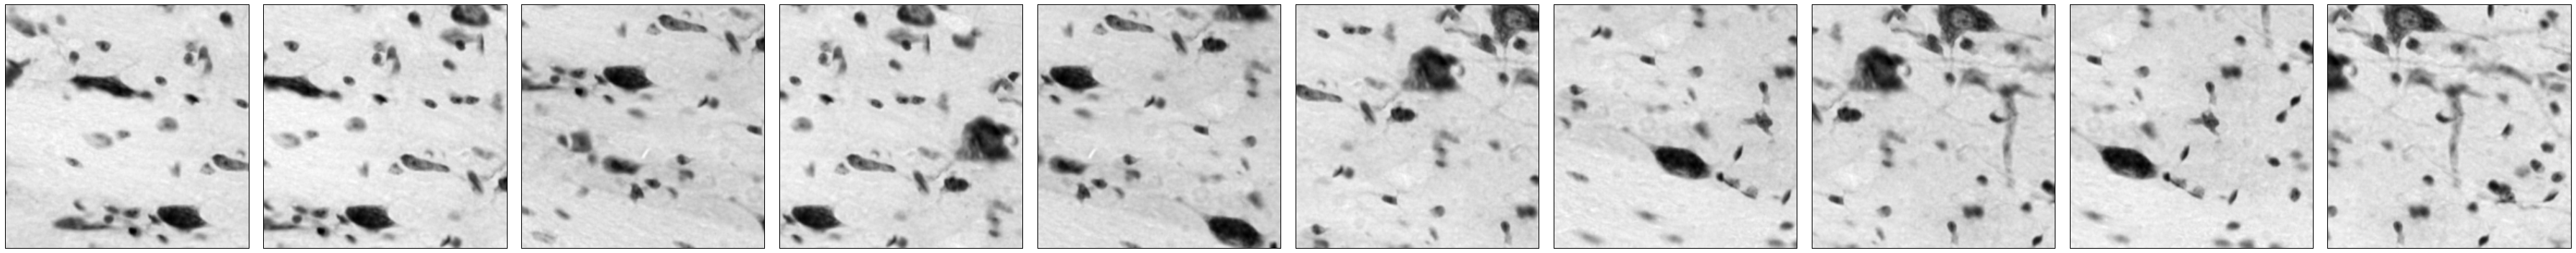

In [91]:
q = \
extract_patches_given_locations_multiple_sections(addresses=positive_addresses_traindata[:10],
                                                  win_id=win_id, 
                                                normalization_scheme='normalize_mu_region_sigma_wholeImage',
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

In [104]:
print np.min(np.reshape(q, (len(q),-1)), axis=1)
print np.max(np.reshape(q, (len(q),-1)), axis=1)

[-4.87647052 -4.56081285 -5.32958402 -4.34534938 -4.35989216 -4.56911308
 -5.85236808 -4.45814275 -5.58977608 -4.75877504]
[ 1.03647475  0.98794368  1.46633734  1.14326955  1.3872762   1.21589296
  1.27978218  1.30224342  1.20751464  1.2153017 ]


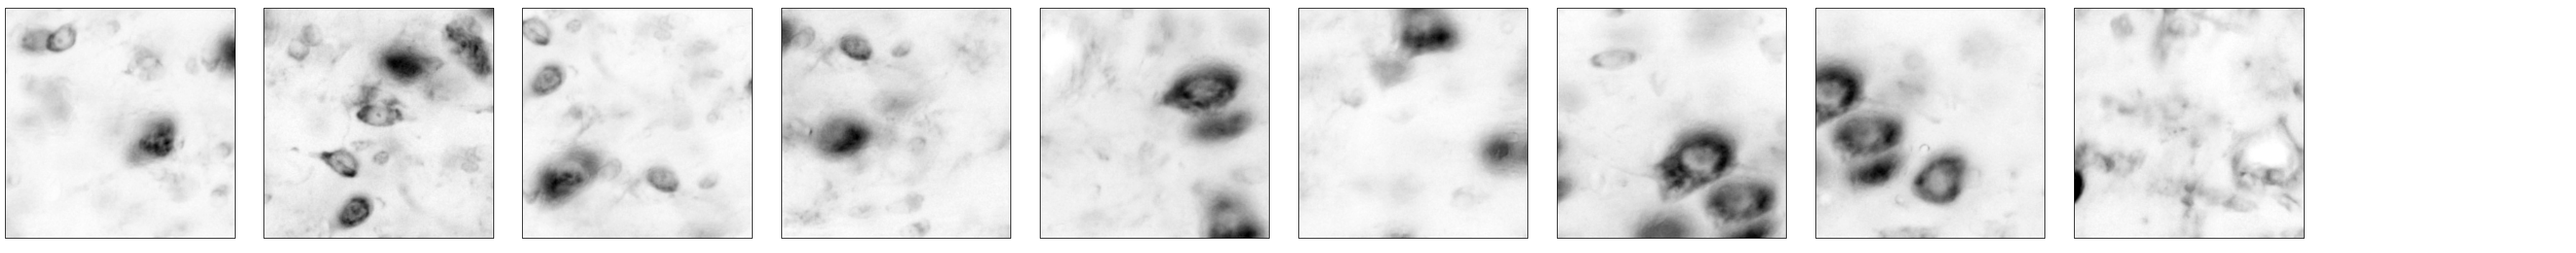

In [22]:
e1 = len(positive_addresses_traindata) + len(negative_addresses_traindata)
e2 = len(positive_addresses_traindata) + len(negative_addresses_traindata) + len(positive_addresses_testdata) 
display_images_in_grids(patches_with_desired_label[e1+10:e1+100:10], nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

In [ ]:
def compute_classification_metrics(probs, labels):
    """
    Args:
        probs ((n,)-array of prediction value between 0 and 1): prediction.
        labels ((n,)-array of 0/1 or -1/1): ground-truth labels.
        
    Returns:
    """

    precision_allthresh = {}
    recall_allthresh = {}
    f1score_allthresh = {}
    tp_normalized_allthresh = {}
    fp_normalized_allthresh = {}
    acc_allthresh = {}
    
    n_pos = np.count_nonzero(labels == 1)
    n_neg = np.count_nonzero(labels != 1)
    n = len(labels)
    
    for th in np.arange(0., 1., 0.01):

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in labels], soft=False,
                                     normalize=False, binary=True, decision_thresh=th)
        tp = cm[0,0]
        fn = cm[0,1]
        fp = cm[1,0]
        tn = cm[1,1]
        
        acc = (tp + tn) / float(n)

        tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
        fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        f1score = 2*recall*precision/(recall+precision)

        tp_normalized_allthresh[float(th)] = tp_normalized
        fp_normalized_allthresh[float(th)] = fp_normalized
        precision_allthresh[float(th)] = precision
        recall_allthresh[float(th)] = recall
        f1score_allthresh[float(th)] = f1score
        acc_allthresh[float(th)] = acc
        
    optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f1score_allthresh[th] for th in np.arange(0, 1, 0.01)])]            
    fopt = f1score_allthresh[optimal_th]

    return {'acc': acc_allthresh,
        'tp': tp_normalized_allthresh,
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
    'fp': fp_normalized_allthresh,
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
    'precision': precision_allthresh,
    'recall': recall_allthresh,
    'f1score': f1score_allthresh,
           'opt_thresh': optimal_th,
           'fopt': fopt}

In [231]:
# n_train_list = [10, 50, 100,500,1000,2000,5000]
n_train_list = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 9000, 10000, 12000, 14000, 16000]
test_f1s_all_ntrain = {}
test_accs_all_ntrain = {}

In [ ]:
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
train_scheme = 'none'
test_scheme = 'none'

for n_train in n_train_list:

    training_accuracies = defaultdict(list)
    test_accuracies = defaultdict(list)
    training_f1s = defaultdict(list)
    test_f1s = defaultdict(list)

    for trial in range(10):

        # If train and test data are from different sets
    #     n_train_pos = 5000
        n_train_pos = n_train
        training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
        n_test_pos = 1000
        test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                            size=n_test_pos, 
                                            replace=False)

        # If train and test are from same set
    #     n_pos_total = len(positive_addresses)
    #     n_train_pos = 1000
    #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
    #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
    #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
    #     n_test_pos = len(test_pos_indices)

        ###############

        # If train and test data are from different sets
    #     n_train_neg = 5000
        n_train_neg = n_train
        training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
        n_test_neg = 1000
        test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                            size=n_test_neg, 
                                            replace=False)

        # If train and test are from same set
    #     n_neg_total = len(negative_addresses)
    #     n_train_neg = 1000
    #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
    #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
    #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
    #     n_test_neg = len(test_neg_indices)

        print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
        print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

        ################

        # If train and test data are from different sets
        addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
        addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
        addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
        addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

        # If train and test data are from same set
    #     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
    #     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
    #     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
    #     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

        #################

        for augment_training in [True, False]:
#         for augment_training in [False]:

            feature_classifier_alg = 'lr'
    #             feature_classifier_alg = 'xgb2'
    #             feature_classifier_alg = 'lin_svc'
    #             feature_classifier_alg = 'lin_svc_calib'
            sample_weights = None   

            if augment_training:
                train_transforms = range(8)
            else:
                train_transforms = range(1)
                
            test_transforms = range(1)
                
            features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                                  [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                   for addr in addresses_train_pos]
                                      for tf_variant in train_transforms}
            features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                                  [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                   for addr in addresses_train_neg]
                                      for tf_variant in train_transforms}
            features_test_pos = {(test_scheme, 'transform%d'%tf_variant): 
                                 [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr] 
                                  for addr in addresses_test_pos]
                                     for tf_variant in test_transforms}
            features_test_neg = {(test_scheme, 'transform%d'%tf_variant): 
                                 [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr]
                                  for addr in addresses_test_neg]
                                     for tf_variant in test_transforms}    
                
            if augment_training:
                
                train_data_list = []
                train_label_list = []
                for tf in range(8):
                    train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                                       features_train_neg[(train_scheme,'transform%d'%tf)]]
                    train_data_list.append(train_data)

                    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                                         -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
                    train_label_list.append(train_labels)

                train_data = np.concatenate(train_data_list)
                train_labels = np.concatenate(train_label_list)        
            else:
                
                train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                                   features_train_neg[(train_scheme,'transform0')]]
                train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                                     -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


            clf = train_binary_classifier(train_data, train_labels,
                                   alg=feature_classifier_alg, 
                                   sample_weights=sample_weights)

            #     trained_classifiers[structure] = clf

            #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
            #         create_parent_dir_if_not_exists(clf_fp)
            #         joblib.dump(clf, clf_fp)
            #         upload_to_s3(clf_fp)

            train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
            train_optthresh = train_metrics['opt_thresh']
            train_acc = train_metrics['acc'][train_optthresh]
    #             train_acc = accuracy_score(train_labels, clf.predict(train_data), normalize=True)
            print "Training accuracy = %.3f, optimal threshold = %.3f" % (train_acc, train_optthresh)
            training_accuracies[(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_acc)
            training_f1s[(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics['fopt'])

            test_data = np.r_[features_test_pos[(test_scheme,'transform0')], features_test_neg[(test_scheme,'transform0')]]
            test_labels = np.r_[np.ones((len(features_test_pos[(test_scheme,'transform0')]), )), 
                                 -np.ones((len(features_test_neg[(test_scheme,'transform0')]), ))]
            test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
            test_optthresh = test_metrics['opt_thresh']
            test_acc = test_metrics['acc'][train_optthresh]
    #             test_acc = accuracy_score(test_labels, clf.predict(test_data), normalize=True)
            print "Test accuracy = %.3f, optimal threshold = %.3f, acc@0.5 = %.3f" % (test_acc, test_optthresh, test_metrics['acc'][0.5])
            test_accuracies[(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_acc)
            test_f1s[(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics['fopt'])

    test_f1s_all_ntrain[n_train] = test_f1s
    test_accs_all_ntrain[n_train] = test_accuracies

Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.270


Fitting classifier: 0.01 seconds


Test accuracy = 0.665, optimal threshold = 0.490, acc@0.5 = 0.713
Training accuracy = 1.000, optimal threshold = 0.160


Fitting classifier: 0.00 seconds


Test accuracy = 0.593, optimal threshold = 0.570, acc@0.5 = 0.717
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.220


Fitting classifier: 0.01 seconds


Test accuracy = 0.698, optimal threshold = 0.200, acc@0.5 = 0.698
Training accuracy = 1.000, optimal threshold = 0.200


Fitting classifier: 0.00 seconds


Test accuracy = 0.636, optimal threshold = 0.470, acc@0.5 = 0.705
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.190


Fitting classifier: 0.02 seconds


Test accuracy = 0.710, optimal threshold = 0.430, acc@0.5 = 0.751
Training accuracy = 1.000, optimal threshold = 0.170


Fitting classifier: 0.00 seconds


Test accuracy = 0.588, optimal threshold = 0.520, acc@0.5 = 0.724
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.250


Fitting classifier: 0.01 seconds


Test accuracy = 0.686, optimal threshold = 0.700, acc@0.5 = 0.720
Training accuracy = 1.000, optimal threshold = 0.200


Fitting classifier: 0.00 seconds


Test accuracy = 0.628, optimal threshold = 0.630, acc@0.5 = 0.696
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.140


Fitting classifier: 0.02 seconds


Test accuracy = 0.587, optimal threshold = 0.530, acc@0.5 = 0.676
Training accuracy = 1.000, optimal threshold = 0.130


Fitting classifier: 0.00 seconds


Test accuracy = 0.543, optimal threshold = 0.430, acc@0.5 = 0.716
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.100


Fitting classifier: 0.01 seconds


Test accuracy = 0.690, optimal threshold = 0.750, acc@0.5 = 0.777
Training accuracy = 1.000, optimal threshold = 0.120


Fitting classifier: 0.00 seconds


Test accuracy = 0.629, optimal threshold = 0.690, acc@0.5 = 0.778
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.200


Fitting classifier: 0.02 seconds


Test accuracy = 0.771, optimal threshold = 0.400, acc@0.5 = 0.812
Training accuracy = 1.000, optimal threshold = 0.140


Fitting classifier: 0.00 seconds


Test accuracy = 0.664, optimal threshold = 0.440, acc@0.5 = 0.799
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.240


Fitting classifier: 0.02 seconds


Test accuracy = 0.618, optimal threshold = 0.840, acc@0.5 = 0.692
Training accuracy = 1.000, optimal threshold = 0.210


Fitting classifier: 0.00 seconds


Test accuracy = 0.553, optimal threshold = 0.750, acc@0.5 = 0.675
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.150


Fitting classifier: 0.01 seconds


Test accuracy = 0.745, optimal threshold = 0.510, acc@0.5 = 0.803
Training accuracy = 1.000, optimal threshold = 0.130


Fitting classifier: 0.00 seconds


Test accuracy = 0.658, optimal threshold = 0.580, acc@0.5 = 0.796
Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative
Training accuracy = 1.000, optimal threshold = 0.100


Fitting classifier: 0.01 seconds


Test accuracy = 0.724, optimal threshold = 0.340, acc@0.5 = 0.795
Training accuracy = 1.000, optimal threshold = 0.120


Fitting classifier: 0.00 seconds


Test accuracy = 0.670, optimal threshold = 0.470, acc@0.5 = 0.787
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.12 seconds


Training accuracy = 0.995, optimal threshold = 0.450
Test accuracy = 0.827, optimal threshold = 0.180, acc@0.5 = 0.827
Training accuracy = 1.000, optimal threshold = 0.350


Fitting classifier: 0.01 seconds


Test accuracy = 0.806, optimal threshold = 0.390, acc@0.5 = 0.815
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.11 seconds


Training accuracy = 0.994, optimal threshold = 0.330
Test accuracy = 0.812, optimal threshold = 0.520, acc@0.5 = 0.826
Training accuracy = 1.000, optimal threshold = 0.230


Fitting classifier: 0.01 seconds


Test accuracy = 0.773, optimal threshold = 0.530, acc@0.5 = 0.814
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.12 seconds


Training accuracy = 0.996, optimal threshold = 0.380
Test accuracy = 0.811, optimal threshold = 0.420, acc@0.5 = 0.815
Training accuracy = 1.000, optimal threshold = 0.360


Fitting classifier: 0.01 seconds


Test accuracy = 0.793, optimal threshold = 0.550, acc@0.5 = 0.806
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.17 seconds


Training accuracy = 0.991, optimal threshold = 0.460
Test accuracy = 0.794, optimal threshold = 0.580, acc@0.5 = 0.800
Training accuracy = 1.000, optimal threshold = 0.310


Fitting classifier: 0.01 seconds


Test accuracy = 0.734, optimal threshold = 0.660, acc@0.5 = 0.772
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.11 seconds


Training accuracy = 0.994, optimal threshold = 0.410
Test accuracy = 0.753, optimal threshold = 0.510, acc@0.5 = 0.769
Training accuracy = 1.000, optimal threshold = 0.370


Fitting classifier: 0.01 seconds


Test accuracy = 0.729, optimal threshold = 0.480, acc@0.5 = 0.758
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.11 seconds


Training accuracy = 0.991, optimal threshold = 0.470
Test accuracy = 0.788, optimal threshold = 0.380, acc@0.5 = 0.789
Training accuracy = 1.000, optimal threshold = 0.420


Fitting classifier: 0.01 seconds


Test accuracy = 0.799, optimal threshold = 0.430, acc@0.5 = 0.805
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.13 seconds


Training accuracy = 0.998, optimal threshold = 0.370
Test accuracy = 0.814, optimal threshold = 0.260, acc@0.5 = 0.814
Training accuracy = 1.000, optimal threshold = 0.360


Fitting classifier: 0.01 seconds


Test accuracy = 0.803, optimal threshold = 0.380, acc@0.5 = 0.808
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.15 seconds


Training accuracy = 0.989, optimal threshold = 0.490
Test accuracy = 0.738, optimal threshold = 0.300, acc@0.5 = 0.736
Training accuracy = 1.000, optimal threshold = 0.430


Fitting classifier: 0.01 seconds


Test accuracy = 0.755, optimal threshold = 0.630, acc@0.5 = 0.764
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.11 seconds


Training accuracy = 0.994, optimal threshold = 0.470
Test accuracy = 0.798, optimal threshold = 0.480, acc@0.5 = 0.798
Training accuracy = 0.990, optimal threshold = 0.530


Fitting classifier: 0.01 seconds


Test accuracy = 0.799, optimal threshold = 0.480, acc@0.5 = 0.800
Training: 50 positive, 50 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.11 seconds


Training accuracy = 0.996, optimal threshold = 0.510
Test accuracy = 0.781, optimal threshold = 0.600, acc@0.5 = 0.782
Training accuracy = 1.000, optimal threshold = 0.460


Fitting classifier: 0.01 seconds


Test accuracy = 0.783, optimal threshold = 0.580, acc@0.5 = 0.787
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.30 seconds


Training accuracy = 0.981, optimal threshold = 0.420
Test accuracy = 0.831, optimal threshold = 0.390, acc@0.5 = 0.830
Training accuracy = 0.995, optimal threshold = 0.400


Fitting classifier: 0.02 seconds


Test accuracy = 0.787, optimal threshold = 0.530, acc@0.5 = 0.812
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.30 seconds


Training accuracy = 0.973, optimal threshold = 0.580
Test accuracy = 0.780, optimal threshold = 0.410, acc@0.5 = 0.776
Training accuracy = 0.995, optimal threshold = 0.400


Fitting classifier: 0.02 seconds


Test accuracy = 0.777, optimal threshold = 0.440, acc@0.5 = 0.782
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.26 seconds


Training accuracy = 0.979, optimal threshold = 0.410
Test accuracy = 0.804, optimal threshold = 0.390, acc@0.5 = 0.806
Training accuracy = 1.000, optimal threshold = 0.390


Fitting classifier: 0.02 seconds


Test accuracy = 0.809, optimal threshold = 0.360, acc@0.5 = 0.806
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.30 seconds


Training accuracy = 0.981, optimal threshold = 0.490
Test accuracy = 0.824, optimal threshold = 0.480, acc@0.5 = 0.824
Training accuracy = 0.995, optimal threshold = 0.420


Fitting classifier: 0.02 seconds


Test accuracy = 0.821, optimal threshold = 0.500, acc@0.5 = 0.830
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.31 seconds


Training accuracy = 0.979, optimal threshold = 0.480
Test accuracy = 0.795, optimal threshold = 0.230, acc@0.5 = 0.797
Training accuracy = 1.000, optimal threshold = 0.410


Fitting classifier: 0.02 seconds


Test accuracy = 0.771, optimal threshold = 0.520, acc@0.5 = 0.786
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.34 seconds


Training accuracy = 0.978, optimal threshold = 0.540
Test accuracy = 0.796, optimal threshold = 0.320, acc@0.5 = 0.792
Training accuracy = 0.980, optimal threshold = 0.450


Fitting classifier: 0.02 seconds


Test accuracy = 0.812, optimal threshold = 0.340, acc@0.5 = 0.811
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.32 seconds


Training accuracy = 0.979, optimal threshold = 0.480
Test accuracy = 0.806, optimal threshold = 0.420, acc@0.5 = 0.806
Training accuracy = 0.990, optimal threshold = 0.500


Fitting classifier: 0.02 seconds


Test accuracy = 0.808, optimal threshold = 0.350, acc@0.5 = 0.808
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.27 seconds


Training accuracy = 0.988, optimal threshold = 0.490
Test accuracy = 0.819, optimal threshold = 0.520, acc@0.5 = 0.819
Training accuracy = 0.995, optimal threshold = 0.400


Fitting classifier: 0.02 seconds


Test accuracy = 0.819, optimal threshold = 0.510, acc@0.5 = 0.828
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.29 seconds


Training accuracy = 0.984, optimal threshold = 0.450
Test accuracy = 0.802, optimal threshold = 0.460, acc@0.5 = 0.803
Training accuracy = 0.995, optimal threshold = 0.500


Fitting classifier: 0.02 seconds


Test accuracy = 0.814, optimal threshold = 0.550, acc@0.5 = 0.814
Training: 100 positive, 100 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.28 seconds


Training accuracy = 0.989, optimal threshold = 0.420
Test accuracy = 0.795, optimal threshold = 0.430, acc@0.5 = 0.798
Training accuracy = 0.995, optimal threshold = 0.370


Fitting classifier: 0.02 seconds


Test accuracy = 0.779, optimal threshold = 0.680, acc@0.5 = 0.799
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.83 seconds


Training accuracy = 0.947, optimal threshold = 0.450
Test accuracy = 0.814, optimal threshold = 0.460, acc@0.5 = 0.816


Fitting classifier: 0.06 seconds


Training accuracy = 0.968, optimal threshold = 0.510
Test accuracy = 0.805, optimal threshold = 0.650, acc@0.5 = 0.804
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.82 seconds


Training accuracy = 0.953, optimal threshold = 0.500
Test accuracy = 0.832, optimal threshold = 0.470, acc@0.5 = 0.832


Fitting classifier: 0.05 seconds


Training accuracy = 0.985, optimal threshold = 0.520
Test accuracy = 0.807, optimal threshold = 0.630, acc@0.5 = 0.806
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.73 seconds


Training accuracy = 0.962, optimal threshold = 0.420
Test accuracy = 0.809, optimal threshold = 0.250, acc@0.5 = 0.816


Fitting classifier: 0.05 seconds


Training accuracy = 0.975, optimal threshold = 0.430
Test accuracy = 0.809, optimal threshold = 0.420, acc@0.5 = 0.809
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.75 seconds


Training accuracy = 0.968, optimal threshold = 0.510
Test accuracy = 0.837, optimal threshold = 0.430, acc@0.5 = 0.838


Fitting classifier: 0.05 seconds


Training accuracy = 0.993, optimal threshold = 0.450
Test accuracy = 0.831, optimal threshold = 0.430, acc@0.5 = 0.833
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.75 seconds


Training accuracy = 0.967, optimal threshold = 0.460
Test accuracy = 0.818, optimal threshold = 0.510, acc@0.5 = 0.821


Fitting classifier: 0.05 seconds


Training accuracy = 0.980, optimal threshold = 0.400
Test accuracy = 0.810, optimal threshold = 0.580, acc@0.5 = 0.828
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.73 seconds


Training accuracy = 0.953, optimal threshold = 0.410
Test accuracy = 0.808, optimal threshold = 0.390, acc@0.5 = 0.812


Fitting classifier: 0.05 seconds


Training accuracy = 0.973, optimal threshold = 0.400
Test accuracy = 0.796, optimal threshold = 0.320, acc@0.5 = 0.799
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.77 seconds


Training accuracy = 0.942, optimal threshold = 0.390
Test accuracy = 0.823, optimal threshold = 0.600, acc@0.5 = 0.832


Fitting classifier: 0.05 seconds


Training accuracy = 0.983, optimal threshold = 0.430
Test accuracy = 0.815, optimal threshold = 0.670, acc@0.5 = 0.823
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.85 seconds


Training accuracy = 0.948, optimal threshold = 0.510
Test accuracy = 0.827, optimal threshold = 0.400, acc@0.5 = 0.828


Fitting classifier: 0.05 seconds


Training accuracy = 0.968, optimal threshold = 0.540
Test accuracy = 0.839, optimal threshold = 0.520, acc@0.5 = 0.834
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.81 seconds


Training accuracy = 0.956, optimal threshold = 0.520
Test accuracy = 0.834, optimal threshold = 0.540, acc@0.5 = 0.832


Fitting classifier: 0.05 seconds


Training accuracy = 0.980, optimal threshold = 0.450
Test accuracy = 0.823, optimal threshold = 0.450, acc@0.5 = 0.821
Training: 200 positive, 200 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.68 seconds


Training accuracy = 0.969, optimal threshold = 0.420
Test accuracy = 0.820, optimal threshold = 0.390, acc@0.5 = 0.821


Fitting classifier: 0.05 seconds


Training accuracy = 0.988, optimal threshold = 0.510
Test accuracy = 0.836, optimal threshold = 0.540, acc@0.5 = 0.834
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.31 seconds


Training accuracy = 0.943, optimal threshold = 0.490
Test accuracy = 0.812, optimal threshold = 0.630, acc@0.5 = 0.814


Fitting classifier: 0.08 seconds


Training accuracy = 0.973, optimal threshold = 0.500
Test accuracy = 0.824, optimal threshold = 0.650, acc@0.5 = 0.824
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.37 seconds


Training accuracy = 0.946, optimal threshold = 0.420
Test accuracy = 0.818, optimal threshold = 0.530, acc@0.5 = 0.824


Fitting classifier: 0.09 seconds


Training accuracy = 0.973, optimal threshold = 0.510
Test accuracy = 0.816, optimal threshold = 0.590, acc@0.5 = 0.817
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.39 seconds


Training accuracy = 0.945, optimal threshold = 0.430
Test accuracy = 0.826, optimal threshold = 0.440, acc@0.5 = 0.828


Fitting classifier: 0.09 seconds


Training accuracy = 0.975, optimal threshold = 0.510
Test accuracy = 0.826, optimal threshold = 0.580, acc@0.5 = 0.826
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.20 seconds


Training accuracy = 0.949, optimal threshold = 0.510
Test accuracy = 0.823, optimal threshold = 0.390, acc@0.5 = 0.823


Fitting classifier: 0.08 seconds


Training accuracy = 0.970, optimal threshold = 0.470
Test accuracy = 0.817, optimal threshold = 0.510, acc@0.5 = 0.818
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.24 seconds


Training accuracy = 0.928, optimal threshold = 0.470
Test accuracy = 0.817, optimal threshold = 0.560, acc@0.5 = 0.817


Fitting classifier: 0.09 seconds


Training accuracy = 0.962, optimal threshold = 0.530
Test accuracy = 0.827, optimal threshold = 0.490, acc@0.5 = 0.826
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.58 seconds


Training accuracy = 0.935, optimal threshold = 0.420
Test accuracy = 0.830, optimal threshold = 0.280, acc@0.5 = 0.832


Fitting classifier: 0.10 seconds


Training accuracy = 0.963, optimal threshold = 0.470
Test accuracy = 0.842, optimal threshold = 0.510, acc@0.5 = 0.846
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.26 seconds


Training accuracy = 0.933, optimal threshold = 0.490
Test accuracy = 0.830, optimal threshold = 0.360, acc@0.5 = 0.831


Fitting classifier: 0.09 seconds


Training accuracy = 0.973, optimal threshold = 0.520
Test accuracy = 0.837, optimal threshold = 0.480, acc@0.5 = 0.835
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.40 seconds


Training accuracy = 0.936, optimal threshold = 0.500
Test accuracy = 0.814, optimal threshold = 0.390, acc@0.5 = 0.814


Fitting classifier: 0.09 seconds


Training accuracy = 0.967, optimal threshold = 0.510
Test accuracy = 0.817, optimal threshold = 0.360, acc@0.5 = 0.817
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.25 seconds


Training accuracy = 0.949, optimal threshold = 0.460
Test accuracy = 0.802, optimal threshold = 0.270, acc@0.5 = 0.807


Fitting classifier: 0.09 seconds


Training accuracy = 0.977, optimal threshold = 0.420
Test accuracy = 0.803, optimal threshold = 0.480, acc@0.5 = 0.809
Training: 300 positive, 300 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.41 seconds


Training accuracy = 0.930, optimal threshold = 0.460
Test accuracy = 0.822, optimal threshold = 0.530, acc@0.5 = 0.826


Fitting classifier: 0.10 seconds


Training accuracy = 0.957, optimal threshold = 0.530
Test accuracy = 0.812, optimal threshold = 0.520, acc@0.5 = 0.809
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.78 seconds


Training accuracy = 0.937, optimal threshold = 0.440
Test accuracy = 0.834, optimal threshold = 0.660, acc@0.5 = 0.833


Fitting classifier: 0.13 seconds


Training accuracy = 0.963, optimal threshold = 0.430
Test accuracy = 0.836, optimal threshold = 0.510, acc@0.5 = 0.842
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.02 seconds


Training accuracy = 0.934, optimal threshold = 0.470
Test accuracy = 0.834, optimal threshold = 0.480, acc@0.5 = 0.836


Fitting classifier: 0.15 seconds


Training accuracy = 0.964, optimal threshold = 0.490
Test accuracy = 0.840, optimal threshold = 0.590, acc@0.5 = 0.840
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.98 seconds


Training accuracy = 0.918, optimal threshold = 0.430
Test accuracy = 0.824, optimal threshold = 0.400, acc@0.5 = 0.829


Fitting classifier: 0.12 seconds


Training accuracy = 0.944, optimal threshold = 0.520
Test accuracy = 0.826, optimal threshold = 0.440, acc@0.5 = 0.825
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.92 seconds


Training accuracy = 0.929, optimal threshold = 0.420
Test accuracy = 0.809, optimal threshold = 0.610, acc@0.5 = 0.827


Fitting classifier: 0.14 seconds


Training accuracy = 0.961, optimal threshold = 0.520
Test accuracy = 0.826, optimal threshold = 0.590, acc@0.5 = 0.825
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.04 seconds


Training accuracy = 0.934, optimal threshold = 0.450
Test accuracy = 0.829, optimal threshold = 0.370, acc@0.5 = 0.828


Fitting classifier: 0.12 seconds


Training accuracy = 0.969, optimal threshold = 0.460
Test accuracy = 0.828, optimal threshold = 0.490, acc@0.5 = 0.831
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.09 seconds


Training accuracy = 0.939, optimal threshold = 0.470
Test accuracy = 0.842, optimal threshold = 0.320, acc@0.5 = 0.843


Fitting classifier: 0.15 seconds


Training accuracy = 0.958, optimal threshold = 0.500
Test accuracy = 0.843, optimal threshold = 0.460, acc@0.5 = 0.843
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.09 seconds


Training accuracy = 0.927, optimal threshold = 0.480
Test accuracy = 0.823, optimal threshold = 0.360, acc@0.5 = 0.827


Fitting classifier: 0.12 seconds


Training accuracy = 0.951, optimal threshold = 0.440
Test accuracy = 0.818, optimal threshold = 0.590, acc@0.5 = 0.824
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.97 seconds


Training accuracy = 0.925, optimal threshold = 0.450
Test accuracy = 0.827, optimal threshold = 0.550, acc@0.5 = 0.836


Fitting classifier: 0.12 seconds


Training accuracy = 0.965, optimal threshold = 0.500
Test accuracy = 0.829, optimal threshold = 0.480, acc@0.5 = 0.829
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.72 seconds


Training accuracy = 0.939, optimal threshold = 0.520
Test accuracy = 0.834, optimal threshold = 0.350, acc@0.5 = 0.833


Fitting classifier: 0.12 seconds


Training accuracy = 0.968, optimal threshold = 0.440
Test accuracy = 0.830, optimal threshold = 0.270, acc@0.5 = 0.828
Training: 400 positive, 400 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.83 seconds


Training accuracy = 0.921, optimal threshold = 0.420
Test accuracy = 0.806, optimal threshold = 0.620, acc@0.5 = 0.816


Fitting classifier: 0.14 seconds


Training accuracy = 0.959, optimal threshold = 0.470
Test accuracy = 0.812, optimal threshold = 0.490, acc@0.5 = 0.815
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.83 seconds


Training accuracy = 0.921, optimal threshold = 0.460
Test accuracy = 0.827, optimal threshold = 0.400, acc@0.5 = 0.831


Fitting classifier: 0.16 seconds


Training accuracy = 0.954, optimal threshold = 0.430
Test accuracy = 0.816, optimal threshold = 0.300, acc@0.5 = 0.823
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.78 seconds


Training accuracy = 0.911, optimal threshold = 0.430
Test accuracy = 0.811, optimal threshold = 0.490, acc@0.5 = 0.814


Fitting classifier: 0.17 seconds


Training accuracy = 0.941, optimal threshold = 0.350
Test accuracy = 0.803, optimal threshold = 0.620, acc@0.5 = 0.824
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.50 seconds


Training accuracy = 0.917, optimal threshold = 0.440
Test accuracy = 0.835, optimal threshold = 0.420, acc@0.5 = 0.837


Fitting classifier: 0.20 seconds


Training accuracy = 0.945, optimal threshold = 0.350
Test accuracy = 0.810, optimal threshold = 0.270, acc@0.5 = 0.819
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.72 seconds


Training accuracy = 0.933, optimal threshold = 0.460
Test accuracy = 0.850, optimal threshold = 0.450, acc@0.5 = 0.851


Fitting classifier: 0.16 seconds


Training accuracy = 0.958, optimal threshold = 0.500
Test accuracy = 0.839, optimal threshold = 0.520, acc@0.5 = 0.839
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.38 seconds


Training accuracy = 0.921, optimal threshold = 0.450
Test accuracy = 0.837, optimal threshold = 0.360, acc@0.5 = 0.840


Fitting classifier: 0.17 seconds


Training accuracy = 0.950, optimal threshold = 0.440
Test accuracy = 0.846, optimal threshold = 0.390, acc@0.5 = 0.846
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.69 seconds


Training accuracy = 0.925, optimal threshold = 0.430
Test accuracy = 0.837, optimal threshold = 0.520, acc@0.5 = 0.843


Fitting classifier: 0.16 seconds


Training accuracy = 0.963, optimal threshold = 0.470
Test accuracy = 0.823, optimal threshold = 0.480, acc@0.5 = 0.822
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.78 seconds


Training accuracy = 0.928, optimal threshold = 0.470
Test accuracy = 0.820, optimal threshold = 0.390, acc@0.5 = 0.823


Fitting classifier: 0.17 seconds


Training accuracy = 0.959, optimal threshold = 0.500
Test accuracy = 0.820, optimal threshold = 0.660, acc@0.5 = 0.820
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.83 seconds


Training accuracy = 0.918, optimal threshold = 0.460
Test accuracy = 0.822, optimal threshold = 0.390, acc@0.5 = 0.821


Fitting classifier: 0.19 seconds


Training accuracy = 0.952, optimal threshold = 0.430
Test accuracy = 0.831, optimal threshold = 0.450, acc@0.5 = 0.835
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.41 seconds


Training accuracy = 0.925, optimal threshold = 0.460
Test accuracy = 0.826, optimal threshold = 0.430, acc@0.5 = 0.827


Fitting classifier: 0.19 seconds


Training accuracy = 0.964, optimal threshold = 0.470
Test accuracy = 0.831, optimal threshold = 0.610, acc@0.5 = 0.833
Training: 500 positive, 500 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.37 seconds


Training accuracy = 0.922, optimal threshold = 0.430
Test accuracy = 0.832, optimal threshold = 0.450, acc@0.5 = 0.834


Fitting classifier: 0.18 seconds


Training accuracy = 0.958, optimal threshold = 0.450
Test accuracy = 0.819, optimal threshold = 0.540, acc@0.5 = 0.823
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.88 seconds


Training accuracy = 0.904, optimal threshold = 0.460
Test accuracy = 0.854, optimal threshold = 0.440, acc@0.5 = 0.850


Fitting classifier: 0.42 seconds


Training accuracy = 0.935, optimal threshold = 0.420
Test accuracy = 0.842, optimal threshold = 0.360, acc@0.5 = 0.842
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.12 seconds


Training accuracy = 0.908, optimal threshold = 0.480
Test accuracy = 0.839, optimal threshold = 0.360, acc@0.5 = 0.842


Fitting classifier: 0.47 seconds


Training accuracy = 0.930, optimal threshold = 0.520
Test accuracy = 0.838, optimal threshold = 0.400, acc@0.5 = 0.837
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.29 seconds


Training accuracy = 0.907, optimal threshold = 0.460
Test accuracy = 0.831, optimal threshold = 0.480, acc@0.5 = 0.833


Fitting classifier: 0.41 seconds


Training accuracy = 0.941, optimal threshold = 0.510
Test accuracy = 0.827, optimal threshold = 0.420, acc@0.5 = 0.828
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 5.88 seconds


Training accuracy = 0.905, optimal threshold = 0.470
Test accuracy = 0.840, optimal threshold = 0.310, acc@0.5 = 0.844


Fitting classifier: 0.41 seconds


Training accuracy = 0.933, optimal threshold = 0.530
Test accuracy = 0.841, optimal threshold = 0.400, acc@0.5 = 0.840
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.11 seconds


Training accuracy = 0.901, optimal threshold = 0.440
Test accuracy = 0.829, optimal threshold = 0.410, acc@0.5 = 0.831


Fitting classifier: 0.42 seconds


Training accuracy = 0.929, optimal threshold = 0.470
Test accuracy = 0.832, optimal threshold = 0.470, acc@0.5 = 0.832
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.86 seconds


Training accuracy = 0.896, optimal threshold = 0.410
Test accuracy = 0.830, optimal threshold = 0.400, acc@0.5 = 0.826


Fitting classifier: 0.44 seconds


Training accuracy = 0.922, optimal threshold = 0.430
Test accuracy = 0.831, optimal threshold = 0.450, acc@0.5 = 0.833
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.70 seconds


Training accuracy = 0.904, optimal threshold = 0.420
Test accuracy = 0.840, optimal threshold = 0.410, acc@0.5 = 0.845


Fitting classifier: 0.43 seconds


Training accuracy = 0.933, optimal threshold = 0.370
Test accuracy = 0.824, optimal threshold = 0.520, acc@0.5 = 0.839
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.05 seconds


Training accuracy = 0.909, optimal threshold = 0.430
Test accuracy = 0.820, optimal threshold = 0.460, acc@0.5 = 0.828


Fitting classifier: 0.47 seconds


Training accuracy = 0.935, optimal threshold = 0.450
Test accuracy = 0.832, optimal threshold = 0.540, acc@0.5 = 0.836
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.33 seconds


Training accuracy = 0.904, optimal threshold = 0.430
Test accuracy = 0.846, optimal threshold = 0.430, acc@0.5 = 0.845


Fitting classifier: 0.46 seconds


Training accuracy = 0.928, optimal threshold = 0.450
Test accuracy = 0.848, optimal threshold = 0.340, acc@0.5 = 0.844
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 5.84 seconds


Training accuracy = 0.914, optimal threshold = 0.440
Test accuracy = 0.851, optimal threshold = 0.400, acc@0.5 = 0.849


Fitting classifier: 0.43 seconds


Training accuracy = 0.931, optimal threshold = 0.490
Test accuracy = 0.854, optimal threshold = 0.370, acc@0.5 = 0.853
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 13.32 seconds


Training accuracy = 0.898, optimal threshold = 0.460
Test accuracy = 0.844, optimal threshold = 0.350, acc@0.5 = 0.848


Fitting classifier: 1.00 seconds


Training accuracy = 0.919, optimal threshold = 0.440
Test accuracy = 0.842, optimal threshold = 0.500, acc@0.5 = 0.847
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 20.32 seconds


Training accuracy = 0.895, optimal threshold = 0.460
Test accuracy = 0.848, optimal threshold = 0.540, acc@0.5 = 0.852


Fitting classifier: 1.07 seconds


Training accuracy = 0.911, optimal threshold = 0.390
Test accuracy = 0.845, optimal threshold = 0.390, acc@0.5 = 0.843
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 15.75 seconds


Training accuracy = 0.901, optimal threshold = 0.460
Test accuracy = 0.845, optimal threshold = 0.450, acc@0.5 = 0.844


Fitting classifier: 1.08 seconds


Training accuracy = 0.923, optimal threshold = 0.380
Test accuracy = 0.846, optimal threshold = 0.370, acc@0.5 = 0.849
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 17.79 seconds


Training accuracy = 0.897, optimal threshold = 0.460
Test accuracy = 0.856, optimal threshold = 0.450, acc@0.5 = 0.856


Fitting classifier: 1.10 seconds


Training accuracy = 0.918, optimal threshold = 0.430
Test accuracy = 0.853, optimal threshold = 0.460, acc@0.5 = 0.857
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 15.14 seconds


Training accuracy = 0.895, optimal threshold = 0.450
Test accuracy = 0.843, optimal threshold = 0.360, acc@0.5 = 0.845


Fitting classifier: 1.03 seconds


Training accuracy = 0.913, optimal threshold = 0.390
Test accuracy = 0.833, optimal threshold = 0.470, acc@0.5 = 0.841
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 15.69 seconds


Training accuracy = 0.895, optimal threshold = 0.410
Test accuracy = 0.849, optimal threshold = 0.530, acc@0.5 = 0.852


Fitting classifier: 1.08 seconds


Training accuracy = 0.915, optimal threshold = 0.420
Test accuracy = 0.854, optimal threshold = 0.350, acc@0.5 = 0.859
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 18.23 seconds


Training accuracy = 0.891, optimal threshold = 0.380
Test accuracy = 0.826, optimal threshold = 0.340, acc@0.5 = 0.832


Fitting classifier: 1.14 seconds


Training accuracy = 0.916, optimal threshold = 0.480
Test accuracy = 0.836, optimal threshold = 0.550, acc@0.5 = 0.839
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 16.69 seconds


Training accuracy = 0.894, optimal threshold = 0.430
Test accuracy = 0.835, optimal threshold = 0.440, acc@0.5 = 0.835


Fitting classifier: 1.08 seconds


Training accuracy = 0.912, optimal threshold = 0.420
Test accuracy = 0.830, optimal threshold = 0.370, acc@0.5 = 0.839
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 17.06 seconds


Training accuracy = 0.890, optimal threshold = 0.420
Test accuracy = 0.843, optimal threshold = 0.440, acc@0.5 = 0.848


Fitting classifier: 1.09 seconds


Training accuracy = 0.909, optimal threshold = 0.430
Test accuracy = 0.844, optimal threshold = 0.540, acc@0.5 = 0.850
Training: 2000 positive, 2000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 17.73 seconds


Training accuracy = 0.897, optimal threshold = 0.400
Test accuracy = 0.848, optimal threshold = 0.460, acc@0.5 = 0.857


Fitting classifier: 1.07 seconds


Training accuracy = 0.917, optimal threshold = 0.420
Test accuracy = 0.849, optimal threshold = 0.500, acc@0.5 = 0.855
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 63.69 seconds


Training accuracy = 0.892, optimal threshold = 0.420
Test accuracy = 0.840, optimal threshold = 0.450, acc@0.5 = 0.843


Fitting classifier: 3.37 seconds


Training accuracy = 0.901, optimal threshold = 0.370
Test accuracy = 0.837, optimal threshold = 0.410, acc@0.5 = 0.845
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 55.70 seconds


Training accuracy = 0.889, optimal threshold = 0.440
Test accuracy = 0.854, optimal threshold = 0.380, acc@0.5 = 0.848


Fitting classifier: 3.21 seconds


Training accuracy = 0.902, optimal threshold = 0.410
Test accuracy = 0.845, optimal threshold = 0.400, acc@0.5 = 0.844
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 58.29 seconds


Training accuracy = 0.894, optimal threshold = 0.420
Test accuracy = 0.843, optimal threshold = 0.290, acc@0.5 = 0.845


Fitting classifier: 3.60 seconds


Training accuracy = 0.908, optimal threshold = 0.410
Test accuracy = 0.851, optimal threshold = 0.430, acc@0.5 = 0.855
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 47.83 seconds


Training accuracy = 0.891, optimal threshold = 0.420
Test accuracy = 0.845, optimal threshold = 0.520, acc@0.5 = 0.852


Fitting classifier: 3.58 seconds


Training accuracy = 0.906, optimal threshold = 0.420
Test accuracy = 0.849, optimal threshold = 0.480, acc@0.5 = 0.853
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 45.60 seconds


Training accuracy = 0.887, optimal threshold = 0.400
Test accuracy = 0.848, optimal threshold = 0.440, acc@0.5 = 0.849


Fitting classifier: 3.50 seconds


Training accuracy = 0.901, optimal threshold = 0.360
Test accuracy = 0.842, optimal threshold = 0.390, acc@0.5 = 0.846
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 62.80 seconds


Training accuracy = 0.889, optimal threshold = 0.440
Test accuracy = 0.846, optimal threshold = 0.470, acc@0.5 = 0.847


Fitting classifier: 3.32 seconds


Training accuracy = 0.904, optimal threshold = 0.380
Test accuracy = 0.838, optimal threshold = 0.430, acc@0.5 = 0.846
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 51.36 seconds


Training accuracy = 0.892, optimal threshold = 0.440
Test accuracy = 0.848, optimal threshold = 0.440, acc@0.5 = 0.848


Fitting classifier: 3.84 seconds


Training accuracy = 0.905, optimal threshold = 0.420
Test accuracy = 0.846, optimal threshold = 0.400, acc@0.5 = 0.847
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 60.07 seconds


Training accuracy = 0.889, optimal threshold = 0.410
Test accuracy = 0.846, optimal threshold = 0.490, acc@0.5 = 0.850


Fitting classifier: 3.31 seconds


Training accuracy = 0.902, optimal threshold = 0.390
Test accuracy = 0.848, optimal threshold = 0.430, acc@0.5 = 0.846
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 55.89 seconds


Training accuracy = 0.891, optimal threshold = 0.420
Test accuracy = 0.837, optimal threshold = 0.570, acc@0.5 = 0.842


Fitting classifier: 3.66 seconds


Training accuracy = 0.901, optimal threshold = 0.420
Test accuracy = 0.833, optimal threshold = 0.280, acc@0.5 = 0.839
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 54.55 seconds


Training accuracy = 0.890, optimal threshold = 0.390
Test accuracy = 0.847, optimal threshold = 0.570, acc@0.5 = 0.853


Fitting classifier: 3.20 seconds


Training accuracy = 0.905, optimal threshold = 0.410
Test accuracy = 0.853, optimal threshold = 0.410, acc@0.5 = 0.853
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 132.11 seconds


Training accuracy = 0.887, optimal threshold = 0.420
Test accuracy = 0.855, optimal threshold = 0.470, acc@0.5 = 0.857


Fitting classifier: 7.65 seconds


Training accuracy = 0.901, optimal threshold = 0.420
Test accuracy = 0.862, optimal threshold = 0.440, acc@0.5 = 0.859
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 126.11 seconds


Training accuracy = 0.889, optimal threshold = 0.430
Test accuracy = 0.851, optimal threshold = 0.440, acc@0.5 = 0.850


Fitting classifier: 8.74 seconds


Training accuracy = 0.902, optimal threshold = 0.440
Test accuracy = 0.842, optimal threshold = 0.520, acc@0.5 = 0.848
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 130.81 seconds


Training accuracy = 0.890, optimal threshold = 0.410
Test accuracy = 0.865, optimal threshold = 0.420, acc@0.5 = 0.870


Fitting classifier: 8.45 seconds


Training accuracy = 0.901, optimal threshold = 0.420
Test accuracy = 0.864, optimal threshold = 0.460, acc@0.5 = 0.868
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 130.61 seconds


Training accuracy = 0.887, optimal threshold = 0.420
Test accuracy = 0.845, optimal threshold = 0.350, acc@0.5 = 0.848


Fitting classifier: 7.89 seconds


Training accuracy = 0.898, optimal threshold = 0.400
Test accuracy = 0.854, optimal threshold = 0.400, acc@0.5 = 0.852
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 132.37 seconds


Training accuracy = 0.884, optimal threshold = 0.400
Test accuracy = 0.863, optimal threshold = 0.370, acc@0.5 = 0.867


Fitting classifier: 7.29 seconds


Training accuracy = 0.898, optimal threshold = 0.450
Test accuracy = 0.867, optimal threshold = 0.380, acc@0.5 = 0.867
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 134.53 seconds


Training accuracy = 0.884, optimal threshold = 0.410
Test accuracy = 0.834, optimal threshold = 0.480, acc@0.5 = 0.842


Fitting classifier: 7.40 seconds


Training accuracy = 0.896, optimal threshold = 0.430
Test accuracy = 0.835, optimal threshold = 0.490, acc@0.5 = 0.844
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 113.89 seconds


Training accuracy = 0.885, optimal threshold = 0.400
Test accuracy = 0.855, optimal threshold = 0.440, acc@0.5 = 0.860


Fitting classifier: 7.14 seconds


Training accuracy = 0.900, optimal threshold = 0.420
Test accuracy = 0.862, optimal threshold = 0.450, acc@0.5 = 0.862
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 107.21 seconds


Training accuracy = 0.886, optimal threshold = 0.390
Test accuracy = 0.843, optimal threshold = 0.390, acc@0.5 = 0.844


Fitting classifier: 7.44 seconds


Training accuracy = 0.899, optimal threshold = 0.430
Test accuracy = 0.837, optimal threshold = 0.490, acc@0.5 = 0.843
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 105.07 seconds


Training accuracy = 0.887, optimal threshold = 0.400
Test accuracy = 0.847, optimal threshold = 0.440, acc@0.5 = 0.849


Fitting classifier: 8.33 seconds


Training accuracy = 0.899, optimal threshold = 0.420
Test accuracy = 0.852, optimal threshold = 0.470, acc@0.5 = 0.855
Training: 9000 positive, 9000 negative
Test: 1000 positive, 1000 negative

Fitting classifier: 124.45 seconds



Training accuracy = 0.889, optimal threshold = 0.410
Test accuracy = 0.860, optimal threshold = 0.480, acc@0.5 = 0.865


Fitting classifier: 7.20 seconds


Training accuracy = 0.899, optimal threshold = 0.420
Test accuracy = 0.859, optimal threshold = 0.520, acc@0.5 = 0.864
Training: 10000 positive, 10000 negative

Fitting classifier: 153.26 seconds



Test: 1000 positive, 1000 negative
Training accuracy = 0.888, optimal threshold = 0.420
Test accuracy = 0.843, optimal threshold = 0.460, acc@0.5 = 0.850


Fitting classifier: 8.95 seconds


Training accuracy = 0.900, optimal threshold = 0.420
Test accuracy = 0.850, optimal threshold = 0.510, acc@0.5 = 0.854
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 121.58 seconds


Training accuracy = 0.888, optimal threshold = 0.430
Test accuracy = 0.845, optimal threshold = 0.400, acc@0.5 = 0.846


Fitting classifier: 8.10 seconds


Training accuracy = 0.899, optimal threshold = 0.410
Test accuracy = 0.843, optimal threshold = 0.350, acc@0.5 = 0.844
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 145.47 seconds


Training accuracy = 0.887, optimal threshold = 0.420
Test accuracy = 0.835, optimal threshold = 0.460, acc@0.5 = 0.838


Fitting classifier: 9.82 seconds


Training accuracy = 0.899, optimal threshold = 0.410
Test accuracy = 0.829, optimal threshold = 0.340, acc@0.5 = 0.834
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 140.79 seconds


Training accuracy = 0.885, optimal threshold = 0.430
Test accuracy = 0.857, optimal threshold = 0.410, acc@0.5 = 0.852


Fitting classifier: 7.63 seconds


Training accuracy = 0.898, optimal threshold = 0.420
Test accuracy = 0.850, optimal threshold = 0.380, acc@0.5 = 0.853
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative

Fitting classifier: 150.88 seconds



Training accuracy = 0.885, optimal threshold = 0.420
Test accuracy = 0.848, optimal threshold = 0.420, acc@0.5 = 0.849


Fitting classifier: 8.89 seconds


Training accuracy = 0.897, optimal threshold = 0.410
Test accuracy = 0.851, optimal threshold = 0.460, acc@0.5 = 0.852
Training: 10000 positive, 10000 negative

Fitting classifier: 151.78 seconds



Test: 1000 positive, 1000 negative
Training accuracy = 0.887, optimal threshold = 0.420
Test accuracy = 0.854, optimal threshold = 0.460, acc@0.5 = 0.852


Fitting classifier: 8.52 seconds


Training accuracy = 0.899, optimal threshold = 0.430
Test accuracy = 0.850, optimal threshold = 0.330, acc@0.5 = 0.853
Training: 10000 positive, 10000 negative

Fitting classifier: 114.90 seconds



Test: 1000 positive, 1000 negative
Training accuracy = 0.886, optimal threshold = 0.430
Test accuracy = 0.861, optimal threshold = 0.500, acc@0.5 = 0.869


Fitting classifier: 7.96 seconds


Training accuracy = 0.898, optimal threshold = 0.460
Test accuracy = 0.858, optimal threshold = 0.340, acc@0.5 = 0.858
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 146.66 seconds


Training accuracy = 0.889, optimal threshold = 0.410
Test accuracy = 0.851, optimal threshold = 0.380, acc@0.5 = 0.849


Fitting classifier: 7.81 seconds


Training accuracy = 0.897, optimal threshold = 0.380
Test accuracy = 0.848, optimal threshold = 0.330, acc@0.5 = 0.847
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 147.67 seconds


Training accuracy = 0.885, optimal threshold = 0.420
Test accuracy = 0.851, optimal threshold = 0.310, acc@0.5 = 0.852


Fitting classifier: 8.02 seconds


Training accuracy = 0.895, optimal threshold = 0.370
Test accuracy = 0.854, optimal threshold = 0.490, acc@0.5 = 0.861
Training: 10000 positive, 10000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 110.11 seconds


Training accuracy = 0.890, optimal threshold = 0.420
Test accuracy = 0.848, optimal threshold = 0.530, acc@0.5 = 0.857


Fitting classifier: 8.07 seconds


Training accuracy = 0.901, optimal threshold = 0.410
Test accuracy = 0.847, optimal threshold = 0.480, acc@0.5 = 0.853
Training: 12000 positive, 12000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 164.69 seconds


Training accuracy = 0.886, optimal threshold = 0.410
Test accuracy = 0.849, optimal threshold = 0.410, acc@0.5 = 0.851


Fitting classifier: 11.28 seconds


Training accuracy = 0.898, optimal threshold = 0.430
Test accuracy = 0.852, optimal threshold = 0.430, acc@0.5 = 0.854
Training: 12000 positive, 12000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 197.89 seconds


Training accuracy = 0.887, optimal threshold = 0.420
Test accuracy = 0.846, optimal threshold = 0.410, acc@0.5 = 0.848


Fitting classifier: 11.73 seconds


Training accuracy = 0.896, optimal threshold = 0.370
Test accuracy = 0.842, optimal threshold = 0.310, acc@0.5 = 0.847
Training: 12000 positive, 12000 negative
Test: 1000 positive, 1000 negative


In [233]:
print 'F1:'
for ntrain, test_f1s in sorted(test_f1s_all_ntrain.items()):
    print ntrain, {k: np.mean(v) for k, v in test_f1s.iteritems()}
    
print 'Acc:'
for ntrain, test_accs in sorted(test_accs_all_ntrain.items()):
    print ntrain, {k: np.mean(v) for k, v in test_accs.iteritems()}

No vtk
No vtk

F1:
10 {('none', 'no-augment'): 0.77083812374196659, ('none', 'augment'): 0.77490607007252954}
50 {('none', 'no-augment'): 0.80539091859682033, ('none', 'augment'): 0.80657179226136999}
100 {('none', 'no-augment'): 0.81901440105387469, ('none', 'augment'): 0.81279538864506462}
200 {('none', 'no-augment'): 0.82990311887012458, ('none', 'augment'): 0.83085695230830259}
300 {('none', 'no-augment'): 0.8300078037653309, ('none', 'augment'): 0.82874581962790528}
400 {('none', 'no-augment'): 0.83685744676518736, ('none', 'augment'): 0.83968238896154657}
500 {('none', 'no-augment'): 0.83442665289389362, ('none', 'augment'): 0.83678675283399129}
1000 {('none', 'no-augment'): 0.84408623065839039, ('none', 'augment'): 0.84411627329744243}
2000 {('none', 'no-augment'): 0.85048723060028597, ('none', 'augment'): 0.85162642092934726}
5000 {('none', 'no-augment'): 0.85239819869146982, ('none', 'augment'): 0.85337470484096123}
9000 {('none', 'no-augment'): 0.86073572630598361, ('none', 'augment'): 0.86

In [ ]:
# optimal number of sections to annotate = required number of patches x 50 mm^3 / volume of entire structure

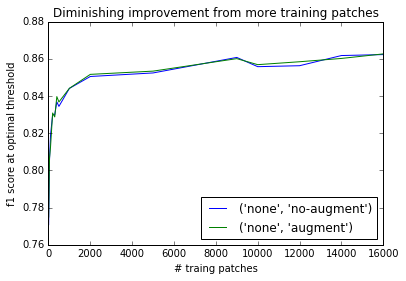

In [234]:
for test_condition in [('none', 'no-augment'), ('none', 'augment')]:
    ntrains, accs = zip(*sorted([(ntrain, np.mean(x[test_condition]))
          for ntrain, x in test_f1s_all_ntrain.iteritems()]))
    plt.plot(ntrains, accs, label=test_condition);
plt.title('Diminishing improvement from more training patches');
plt.xlabel('# traing patches');
plt.ylabel('f1 score at optimal threshold');
plt.legend(loc='lower right');

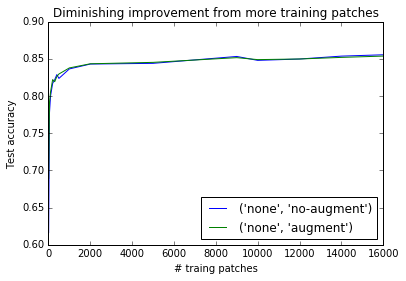

In [236]:
for test_condition in [('none', 'no-augment'), ('none', 'augment')]:
    ntrains, accs = zip(*sorted([(ntrain, np.mean(x[test_condition]))
          for ntrain, x in test_accs_all_ntrain.iteritems()]))
    plt.plot(ntrains, accs, label=test_condition);
plt.title('Diminishing improvement from more training patches');
plt.xlabel('# traing patches');
plt.ylabel('Test accuracy');
plt.legend(loc='lower right');

Mean test F1:
{('normalize_mu_region_sigma_wholeImage_(-1,9)', 'no-augment'): 0.67289021963117635}


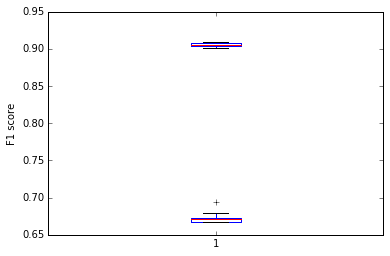

In [71]:
# plt.boxplot(training_accuracies.values(), labels=training_accuracies.keys());
# plt.boxplot(test_accuracies.values(), labels=training_accuracies.keys());
plt.boxplot(training_f1s.values());
plt.boxplot(test_f1s.values());
plt.ylabel('F1 score');
# plt.ylim([0.75, 1.]);

print 'Mean test F1:'
print {k: np.mean(v) for k, v in test_f1s.iteritems()}

Mean test acc:
{('normalize_mu_region_sigma_wholeImage_(-1,9)', 'no-augment'): 0.54725000000000001}


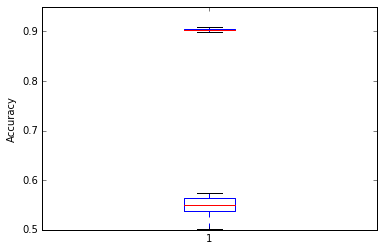

In [72]:
# plt.boxplot(training_accuracies.values(), labels=training_accuracies.keys());
# plt.boxplot(test_accuracies.values(), labels=training_accuracies.keys());
plt.boxplot(training_accuracies.values());
plt.boxplot(test_accuracies.values());
plt.ylabel('Accuracy');
# plt.ylim([0.75, 1.]);

print 'Mean test acc:'
print {k: np.mean(v) for k, v in test_accuracies.iteritems()}

In [39]:
training_accuracies.keys()

[('normalize_mu_region_sigma_wholeImage_(-1,9)', 'no-augment')]

In [39]:
negative_composition_rules = ['surround500']

In [40]:
fixed_n_pos = 500
fixed_n_neg = 500

In [239]:
acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
precision_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
recall_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
f1score_normalized_all_clfs_all_structures_all_negcomprule =  defaultdict(lambda: defaultdict(dict))

classifier_ids = [0]

for classifier_id in classifier_ids:
    
    clf_allClasses = trained_classifiers

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

#             features_pos = test_features[structure]
            features_pos = features_pos_unused
    
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]

            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

#             features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            features_neg = features_neg_unused
    
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]        

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            
            
            ######### SOFT ########
#             cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
#                                              normalize=False)
#             tp = cm[0,0]
#             fn = cm[0,1]
#             fp = cm[1,0]
#             tn = cm[1,1]

#             acc = (tp + tn) / (n_pos + n_neg)
#             acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            ######## PRECISION-RECALL ########
            precision_allthresh = {}
            recall_allthresh = {}
            f1score_allthresh = {}
            tp_normalized_allthresh = {}
            fp_normalized_allthresh = {}
            for th in np.arange(0., 1., 0.01):
            
                cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=False,
                                             normalize=False, binary=True, decision_thresh=th)

                tp = cm[0,0]
                fn = cm[0,1]
                fp = cm[1,0]
                tn = cm[1,1]
                
                tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
                fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

                precision = float(tp) / (tp + fp)
                recall = float(tp) / (tp + fn)
                f1score = 2*recall*precision/(recall+precision)
                
                tp_normalized_allthresh[float(th)] = tp_normalized
                fp_normalized_allthresh[float(th)] = fp_normalized
                precision_allthresh[float(th)] = precision
                recall_allthresh[float(th)] = recall
                f1score_allthresh[float(th)] = f1score

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized_allthresh
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized_allthresh
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
            precision_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = precision_allthresh
            recall_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = recall_allthresh
            f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = f1score_allthresh
    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
precision_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
recall_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
f1score_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

SNR 500 positive
SNR 500 negative


In [240]:
structures_sorted_by_size = ['SNR']

In [241]:
fopt_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
optthresh_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:

    for neg_composition_rule in negative_composition_rules:

        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f_allthresh[th] for th in np.arange(0, 1, 0.01)])]
            optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = optimal_th
            fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = f_allthresh[optimal_th]

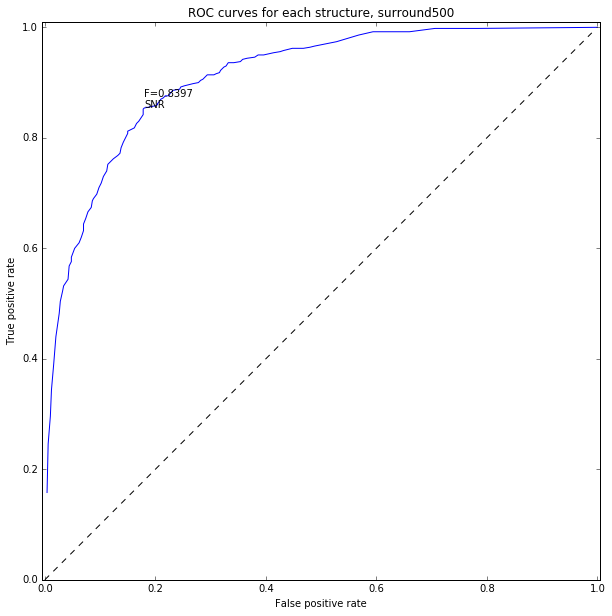

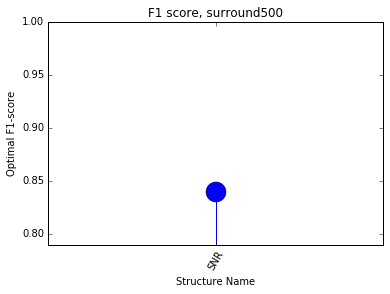

In [242]:
for classifier_id in classifier_ids:
    for neg_composition_rule in negative_composition_rules:

    #     plt.figure(figsize=(15, 10));
        plt.figure(figsize=(10, 10));
        plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

        fopt = {}
        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            plt.plot([fp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)],
                 [tp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)]);

            optimal_th = optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            fopt = f_allthresh[optimal_th]

    #         plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
    #             marker='o', facecolors='none', edgecolors='k')
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th]+.02, 'F=%.4f' % (fopt))
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], s, fontsize=10)

    #     plt.legend();
        plt.ylabel('True positive rate');
        plt.xlabel('False positive rate');
    #     plt.xticks(np.arange(0,1,.1));
        plt.axis('equal');
        plt.ylim([0,1.01]);
        plt.xlim([0,1]);
        plt.title('ROC curves for each structure, %s' % (neg_composition_rule));
        plt.show();

    #     plt.figure();
    #     plt.hist(fopt.values(), bins=np.arange(0.7, 1.0, 0.01));
    #     plt.ylabel("Number of structures");
    #     plt.xlabel("Optimal f1 score");
    #     plt.show();

        plt.figure();
        xticks = range(1, 1 + len(structures_sorted_by_size))
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                                                       [fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size],
         markerfmt='o', markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
        plt.xticks(xticks, structures_sorted_by_size, rotation='60');
        plt.ylabel('Optimal F1-score');
        plt.xlabel('Structure Name');
        plt.ylim(np.min([fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size])-.05, 1);
        plt.title('F1 score, %s' % (neg_composition_rule));
        plt.legend();
        plt.show();